# Demo

In this notebook, we reproduced the original demo within this HDDM docker container. Also, we demonstrated how to use `p_tqdm` for parallel processing.

This script reproduces the [official tutorial of HDDM](http://ski.clps.brown.edu/hddm_docs/tutorial_python.html) by the HDDM (0.9.0) in this docker image.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
import hddm
import kabuki
print(hddm.__version__)

0.9.1


## Loading data

In [3]:
# find the directory of "cavanagh_theta_nn.csv"
print(hddm.__file__)

/opt/conda/lib/python3.8/site-packages/hddm/__init__.py


In [4]:
!head /opt/conda/lib/python3.8/site-packages/hddm/examples/cavanagh_theta_nn.csv

subj_idx,stim,rt,response,theta,dbs,conf
0,LL,1.21,1.0,0.65627512226100004,1,HC
0,WL,1.6299999999999999,1.0,-0.32788867166199998,1,LC
0,WW,1.03,1.0,-0.480284512399,1,HC
0,WL,2.77,1.0,1.9274273452399999,1,LC
0,WW,1.1399999999999999,0.0,-0.21323572605999999,1,HC
0,WL,1.1499999999999999,1.0,-0.43620365940099998,1,LC
0,LL,2.0,1.0,-0.27447891439400002,1,HC
0,WL,1.04,0.0,0.66695707371400004,1,LC
0,WW,0.85699999999999998,1.0,0.11861689909799999,1,HC


In [5]:
data = hddm.load_csv('/opt/conda/lib/python3.8/site-packages/hddm/examples/cavanagh_theta_nn.csv')
data.head()

,subj_idx,stim,rt,response,theta,dbs,conf
0,0,LL,1.21,1.0,0.656275,1,HC
1,0,WL,1.63,1.0,-0.327889,1,LC
2,0,WW,1.03,1.0,-0.480285,1,HC
3,0,WL,2.77,1.0,1.927427,1,LC
4,0,WW,1.14,0.0,-0.213236,1,HC


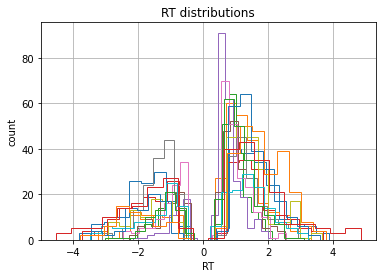

In [6]:
data = hddm.utils.flip_errors(data)

fig = plt.figure()
ax = fig.add_subplot(111, xlabel='RT', ylabel='count', title='RT distributions')
for i, subj_data in data.groupby('subj_idx'):
    subj_data.rt.hist(bins=20, histtype='step', ax=ax)

# plt.savefig('hddm_demo_fig_00.pdf')

Check number of trials of each condition for each participant.

In [7]:
data.groupby(['subj_idx', 'stim']).size()

subj_idx  stim
0         LL       73
          WL      151
          WW       74
1         LL       74
          WL      153
          WW       71
2         LL       73
          WL      147
          WW       73
3         LL       62
          WL      129
          WW       64
4         LL       70
          WL      144
          WW       69
5         LL       77
          WL      155
          WW       71
6         LL       73
          WL      154
          WW       72
7         LL       77
          WL      142
          WW       75
8         LL       74
          WL      148
          WW       71
9         LL       53
          WL      110
          WW       54
10        LL       76
          WL      157
          WW       76
11        LL       73
          WL      153
          WW       79
12        LL       61
          WL      138
          WW       68
13        LL       68
          WL      135
          WW       71
dtype: int64

## Fitting a hierarchical model

In [8]:
# Instantiate model object passing it our data (no need to call flip_errors() before passing it).
# This will tailor an individual hierarchical DDM around your dataset.
m1 = hddm.HDDM(data)
# find a good starting point which helps with the convergence.
m1.find_starting_values()
# start drawing 7000 samples and discarding 5000 as burn-in
m1.sample(2000, burn=500)

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 2000 of 2000 complete in 97.6 sec

In [9]:
stats = m1.gen_stats()
stats[stats.index.isin(['a', 'a_std', 'a_subj.0', 'a_subj.1'])]

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,1.97334,0.095234,1.79388,1.90861,1.97241,2.03563,2.16947,0.00265483
a_std,0.339324,0.0773943,0.225767,0.284626,0.326648,0.379547,0.535106,0.00315394
a_subj.0,2.19961,0.063946,2.07082,2.15911,2.19936,2.2418,2.33144,0.00213003
a_subj.1,2.11368,0.0673304,1.98318,2.06795,2.11376,2.15572,2.24632,0.00261917


Plotting a
Plotting a_std
Plotting v
Plotting t


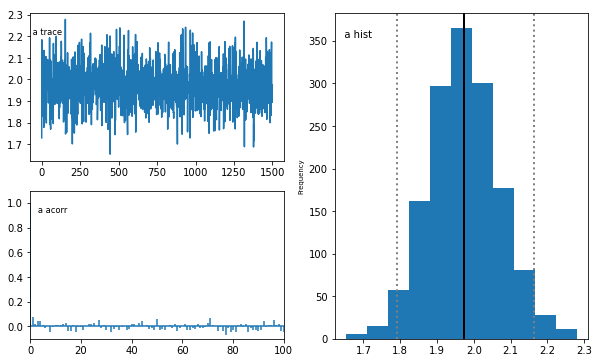

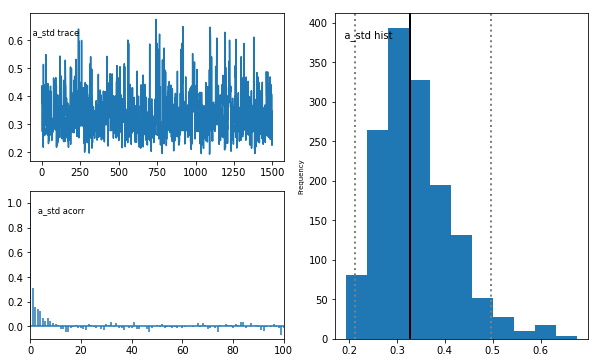

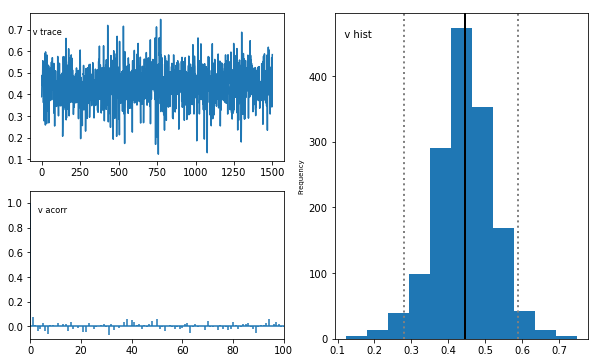

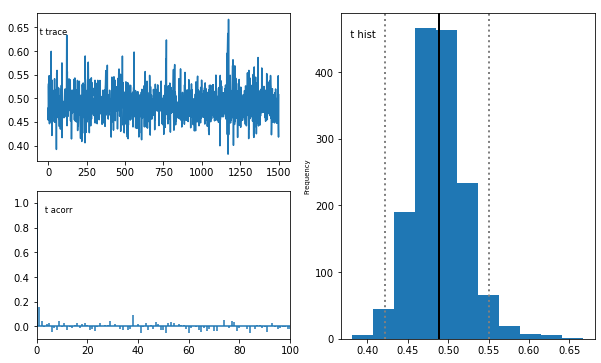

In [10]:
m1.plot_posteriors(['a', 't', 'v', 'a_std'])

## Calculate Gelman_rubin r hat.

### Option 1: using`for` loop

As we can see, it takes 20min 32s on a machine with `Intel® Core™ i7-10700 CPU @ 2.90GHz × 16` 

In [11]:
samples = 5000  # Cavanagh used 30,000 and 10, 000 burn.
burn = 1000    
thin = 1
chains = 5

In [12]:
%%time
models_1_ser = []
for i in range(chains):
    m = hddm.HDDM(data)
    m.find_starting_values()
    m.sample(samples, burn=burn)
    models_1_ser.append(m)

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [-----------------100%-----------------] 5000 of 5000 complete in 237.0 secNo model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 244.9 secNo model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 247.0 secNo model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 243.4 secNo model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 241.4 secCPU times: user 20min 23s, sys: 38.7 s, total: 21min 1s
Wall time: 20min 19s


In [13]:
hddm.analyze.gelman_rubin(models_1_ser)

{'a': 0.9999798295276218,
 'a_std': 1.000164843378307,
 'a_subj.0': 1.0005397027522016,
 'a_subj.1': 1.0000977015173973,
 'a_subj.2': 0.9999202859471921,
 'a_subj.3': 1.0003490553837613,
 'a_subj.4': 0.9999357431841565,
 'a_subj.5': 1.0002324362755888,
 'a_subj.6': 1.0000387758134806,
 'a_subj.7': 1.000215019457604,
 'a_subj.8': 1.0001218733167914,
 'a_subj.9': 0.9998865620324044,
 'a_subj.10': 1.000157549770845,
 'a_subj.11': 1.0003331931793407,
 'a_subj.12': 1.000523080694831,
 'a_subj.13': 1.0003298634459483,
 'v': 1.0000782618480484,
 'v_std': 1.0000996795820651,
 'v_subj.0': 0.9999890931423261,
 'v_subj.1': 1.0000820881251529,
 'v_subj.2': 1.0001404984736888,
 'v_subj.3': 1.0000510343684867,
 'v_subj.4': 0.9999768936073703,
 'v_subj.5': 1.0000830679578814,
 'v_subj.6': 0.9999648659973336,
 'v_subj.7': 0.9999917982745931,
 'v_subj.8': 1.0000486756075715,
 'v_subj.9': 0.9999083319021391,
 'v_subj.10': 1.0000297993460838,
 'v_subj.11': 0.9999428864339311,
 'v_subj.12': 1.000108606445

### Option 2: using `p_tqdm` for parall processing
Here, we replace the `for` loop with parallel processing. As we can see here, the parall processing takes 4min 1s minutes on the same machine. 

In [14]:
# parallel processing related packages
from p_tqdm import p_map
from functools import partial

In [15]:
def ms1(id, data=None, samples=None, burn=None, save_name="cavanagh2011_m1"): 

    print('running model%i'%id);
    
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    m = hddm.HDDM(data)
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [16]:
%%time
models_1_par = p_map(partial(ms1, data=data, samples=samples, burn=burn),
                 range(chains)) # progess bar is a mess ;(

running model0

  0%|          | 0/5 [00:00<?, ?it/s]


No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model1
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model2
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model4
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model3
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


  [                  0%                  ] 12 of 5000 complete in 0.5 sec[                  0%                  ] 12 of 5000 complete in 0.5 sec[                  0%                  ] 11 of 5000 complete in 0.5 sec[                  0%                  ] 9 of 5000 complete in 0.5 sec[                  0%                  ] 9 of 5000 complete in 0.5 sec[                  0%                  ] 22 of 5000 complete in 1.0 sec[                  0%                  ] 21 of 5000 complete in 1.1 sec[                  0%                  ] 21 of 5000 complete in 1.1 sec[                  0%                  ] 17 of 5000 complete in 1.1 sec[                  0%                  ] 17 of 5000 complete in 1.0 sec[                  0%                  ] 33 of 5000 complete in 1.6 sec[                  0%                  ] 32 of 5000 complete in 1.6 sec[                  0%                  ] 30 of 5000 complete in 1.6 sec[                  0%                  ] 26 of 5000 complete in 1.6 sec[     

 [-                 4%                  ] 220 of 5000 complete in 12.5 sec[-                 4%                  ] 217 of 5000 complete in 12.9 sec[-                 4%                  ] 223 of 5000 complete in 12.8 sec[-                 4%                  ] 211 of 5000 complete in 12.5 sec[-                 4%                  ] 224 of 5000 complete in 12.7 sec[-                 4%                  ] 230 of 5000 complete in 13.1 sec[-                 4%                  ] 228 of 5000 complete in 13.4 sec[-                 4%                  ] 233 of 5000 complete in 13.4 sec[-                 4%                  ] 221 of 5000 complete in 13.1 sec[-                 4%                  ] 233 of 5000 complete in 13.2 sec[-                 4%                  ] 240 of 5000 complete in 13.6 sec[-                 4%                  ] 238 of 5000 complete in 13.9 sec[-                 4%                  ] 242 of 5000 complete in 13.9 sec[-                 4%                  ] 243 of 50

 ---              10%                  ] 519 of 5000 complete in 29.9 secc[---               8%                  ] 434 of 5000 complete in 24.7 sec[---               8%                  ] 419 of 5000 complete in 24.3 sec[---               8%                  ] 423 of 5000 complete in 24.9 sec[---               8%                  ] 440 of 5000 complete in 25.0 sec[---               8%                  ] 429 of 5000 complete in 24.8 sec[---               8%                  ] 438 of 5000 complete in 24.9 sec[---               8%                  ] 445 of 5000 complete in 25.2 sec[---               8%                  ] 432 of 5000 complete in 25.5 sec[---               9%                  ] 451 of 5000 complete in 25.6 sec[---               8%                  ] 438 of 5000 complete in 25.3 sec[---               8%                  ] 446 of 5000 complete in 25.4 sec[---               9%                  ] 456 of 5000 complete in 25.8 sec[---               8%                  ] 441 of 50

 -----            13%                  ] 659 of 5000 complete in 38.4 secc[----             12%                  ] 623 of 5000 complete in 36.5 sec[----             13%                  ] 656 of 5000 complete in 36.9 sec[----             12%                  ] 631 of 5000 complete in 36.8 sec[----             12%                  ] 624 of 5000 complete in 37.1 sec[----             12%                  ] 642 of 5000 complete in 37.0 sec[----             12%                  ] 632 of 5000 complete in 37.0 sec[----             12%                  ] 641 of 5000 complete in 37.3 sec[-----            13%                  ] 666 of 5000 complete in 37.4 sec[----             12%                  ] 634 of 5000 complete in 37.7 sec[----             13%                  ] 651 of 5000 complete in 37.5 sec[----             13%                  ] 651 of 5000 complete in 37.9 sec[----             12%                  ] 640 of 5000 complete in 37.5 sec[-----            13%                  ] 677 of 50

 [------           16%                  ] 815 of 5000 complete in 48.7 sec[------           16%                  ] 821 of 5000 complete in 48.4 sec[------           16%                  ] 840 of 5000 complete in 48.7 sec[------           16%                  ] 845 of 5000 complete in 49.0 sec[------           17%                  ] 868 of 5000 complete in 49.1 sec[------           16%                  ] 824 of 5000 complete in 49.3 sec[------           16%                  ] 832 of 5000 complete in 48.9 sec[------           17%                  ] 851 of 5000 complete in 49.2 sec[------           17%                  ] 853 of 5000 complete in 49.5 sec[------           17%                  ] 876 of 5000 complete in 49.6 sec[------           16%                  ] 833 of 5000 complete in 49.8 sec[------           16%                  ] 840 of 5000 complete in 49.4 sec[------           17%                  ] 858 of 5000 complete in 49.7 sec[------           17%                  ] 861 of 50

 [-------          20%                  ] 1012 of 5000 complete in 60.2 sec[-------          20%                  ] 1040 of 5000 complete in 60.6 sec[--------         21%                  ] 1069 of 5000 complete in 60.7 sec[-------          20%                  ] 1025 of 5000 complete in 60.9 sec[-------          20%                  ] 1045 of 5000 complete in 60.7 sec[-------          20%                  ] 1022 of 5000 complete in 60.7 sec[-------          21%                  ] 1050 of 5000 complete in 61.1 sec[--------         21%                  ] 1078 of 5000 complete in 61.3 sec[-------          20%                  ] 1034 of 5000 complete in 61.4 sec[--------         21%                  ] 1055 of 5000 complete in 61.2 sec[-------          20%                  ] 1032 of 5000 complete in 61.2 sec[--------         21%                  ] 1060 of 5000 complete in 61.6 sec[--------         21%                  ] 1089 of 5000 complete in 61.8 sec[-------          20%                

 ----------       26%                  ] 1329 of 5000 complete in 78.4 secc[---------        25%                  ] 1275 of 5000 complete in 72.5 sec[---------        24%                  ] 1235 of 5000 complete in 72.5 sec[---------        24%                  ] 1248 of 5000 complete in 72.2 sec[---------        24%                  ] 1221 of 5000 complete in 72.2 sec[---------        24%                  ] 1244 of 5000 complete in 72.7 sec[---------        25%                  ] 1285 of 5000 complete in 73.0 sec[---------        24%                  ] 1243 of 5000 complete in 73.1 sec[---------        25%                  ] 1259 of 5000 complete in 72.7 sec[---------        24%                  ] 1229 of 5000 complete in 72.7 sec[---------        25%                  ] 1253 of 5000 complete in 73.3 sec[---------        25%                  ] 1294 of 5000 complete in 73.5 sec[---------        25%                  ] 1251 of 5000 complete in 73.6 sec[---------        25%                

 [----------       28%                  ] 1425 of 5000 complete in 84.2 sec[----------       28%                  ] 1425 of 5000 complete in 83.9 sec[----------       28%                  ] 1436 of 5000 complete in 84.3 sec[-----------      29%                  ] 1479 of 5000 complete in 84.7 sec  [-----------      29%                  ] 1466 of 5000 complete in 84.4 sec[----------       28%                  ] 1435 of 5000 complete in 84.7 sec[----------       28%                  ] 1433 of 5000 complete in 84.4 sec[----------       28%                  ] 1446 of 5000 complete in 84.8 sec[-----------      29%                  ] 1489 of 5000 complete in 85.2 sec[----------       28%                  ] 1446 of 5000 complete in 85.3 sec[-----------      29%                  ] 1475 of 5000 complete in 85.0 sec[----------       28%                  ] 1442 of 5000 complete in 84.9 sec[-----------      29%                  ] 1454 of 5000 complete in 85.3 sec[-----------      30%              

 [------------     32%                  ] 1641 of 5000 complete in 95.9 sec[------------     32%                  ] 1630 of 5000 complete in 95.6 sec[------------     33%                  ] 1681 of 5000 complete in 96.4 sec[------------     33%                  ] 1672 of 5000 complete in 96.0 sec[------------     32%                  ] 1638 of 5000 complete in 96.4 sec[------------     33%                  ] 1650 of 5000 complete in 96.5 sec[------------     32%                  ] 1641 of 5000 complete in 96.2 sec[------------     33%                  ] 1691 of 5000 complete in 96.9 sec[------------     33%                  ] 1683 of 5000 complete in 96.6 sec[------------     32%                  ] 1648 of 5000 complete in 96.9 sec[------------     33%                  ] 1660 of 5000 complete in 97.0 sec[------------     33%                  ] 1652 of 5000 complete in 96.7 sec[------------     34%                  ] 1700 of 5000 complete in 97.4 sec[------------     33%                

 [-------------    36%                  ] 1842 of 5000 complete in 107.6 sec[-------------    36%                  ] 1828 of 5000 complete in 107.3 sec[-------------    36%                  ] 1839 of 5000 complete in 107.9 sec[--------------   37%                  ] 1884 of 5000 complete in 108.0 sec[--------------   37%                  ] 1872 of 5000 complete in 107.8 sec[--------------   37%                  ] 1853 of 5000 complete in 108.2 sec[-------------    36%                  ] 1836 of 5000 complete in 107.9 sec[--------------   37%                  ] 1850 of 5000 complete in 108.5 sec[--------------   37%                  ] 1895 of 5000 complete in 108.5 sec[--------------   37%                  ] 1881 of 5000 complete in 108.4 sec[--------------   37%                  ] 1861 of 5000 complete in 108.7 sec[--------------   36%                  ] 1844 of 5000 complete in 108.4 sec[--------------   37%                  ] 1861 of 5000 complete in 109.0 sec[--------------   38%   

 [---------------  40%                  ] 2046 of 5000 complete in 119.2 sec[---------------  40%                  ] 2027 of 5000 complete in 119.0 sec[---------------  40%                  ] 2042 of 5000 complete in 119.6 sec[---------------  41%                  ] 2086 of 5000 complete in 119.6 sec[---------------  41%                  ] 2073 of 5000 complete in 119.3 sec[---------------  41%                  ] 2054 of 5000 complete in 119.8 sec[---------------  40%                  ] 2035 of 5000 complete in 119.5 sec[---------------  41%                  ] 2051 of 5000 complete in 120.1 sec[---------------  41%                  ] 2096 of 5000 complete in 120.2 sec[---------------  41%                  ] 2084 of 5000 complete in 119.9 sec[---------------  41%                  ] 2063 of 5000 complete in 120.3 sec[---------------  40%                  ] 2046 of 5000 complete in 120.0 sec[---------------  41%                  ] 2061 of 5000 complete in 120.7 sec[---------------  42%   

 [-----------------44%                  ] 2240 of 5000 complete in 130.8 sec[---------------- 44%                  ] 2233 of 5000 complete in 130.6 sec[-----------------45%                  ] 2285 of 5000 complete in 131.2 sec[-----------------44%                  ] 2243 of 5000 complete in 131.4 sec[-----------------45%                  ] 2274 of 5000 complete in 131.0 sec[-----------------44%                  ] 2248 of 5000 complete in 131.4 sec[-----------------44%                  ] 2242 of 5000 complete in 131.1 sec[-----------------45%                  ] 2296 of 5000 complete in 131.7 sec[-----------------45%                  ] 2254 of 5000 complete in 131.9 sec[-----------------45%                  ] 2284 of 5000 complete in 131.6 sec[-----------------45%                  ] 2256 of 5000 complete in 131.9 sec[-----------------45%                  ] 2253 of 5000 complete in 131.6 sec[-----------------46%                  ] 2306 of 5000 complete in 132.3 sec[-----------------45%   

 [-----------------49%                  ] 2451 of 5000 complete in 142.5 sec[-----------------48%                  ] 2444 of 5000 complete in 142.2 sec[-----------------49%                  ] 2498 of 5000 complete in 142.8 sec[-----------------49%                  ] 2483 of 5000 complete in 142.5 sec[-----------------49%                  ] 2453 of 5000 complete in 142.9 sec[-----------------49%                  ] 2462 of 5000 complete in 143.0 sec[-----------------49%                  ] 2455 of 5000 complete in 142.8 sec[-----------------49%                  ] 2494 of 5000 complete in 143.0 sec[-----------------50%                  ] 2508 of 5000 complete in 143.3 sec[-----------------49%                  ] 2464 of 5000 complete in 143.4 sec[-----------------49%                  ] 2472 of 5000 complete in 143.5 sec[-----------------49%                  ] 2463 of 5000 complete in 143.3 sec[-----------------50%                  ] 2516 of 5000 complete in 143.8 sec[-----------------50%   

 [-----------------53%                  ] 2659 of 5000 complete in 154.1 sec[-----------------53%                  ] 2658 of 5000 complete in 153.8 sec[-----------------54%                  ] 2715 of 5000 complete in 154.5 sec[-----------------53%                  ] 2697 of 5000 complete in 154.2 sec[-----------------53%                  ] 2665 of 5000 complete in 154.6 sec[-----------------53%                  ] 2677 of 5000 complete in 154.6 sec[-----------------53%                  ] 2664 of 5000 complete in 154.4 sec[-----------------54%                  ] 2704 of 5000 complete in 154.7 sec[-----------------54%                  ] 2723 of 5000 complete in 155.0 sec[-----------------53%                  ] 2674 of 5000 complete in 155.1 sec[-----------------53%                  ] 2686 of 5000 complete in 155.2 sec[-----------------53%                  ] 2674 of 5000 complete in 154.9 sec[-----------------54%                  ] 2715 of 5000 complete in 155.2 sec[-----------------54%   

 [-----------------57%--                ] 2895 of 5000 complete in 165.7 sec[-----------------57%-                 ] 2886 of 5000 complete in 165.3 sec[-----------------58%--                ] 2936 of 5000 complete in 166.1 sec[-----------------57%--                ] 2896 of 5000 complete in 166.1 sec[-----------------58%--                ] 2920 of 5000 complete in 165.8 sec[-----------------58%--                ] 2905 of 5000 complete in 166.3 sec[-----------------57%--                ] 2897 of 5000 complete in 165.9 sec[-----------------58%--                ] 2946 of 5000 complete in 166.6 sec[-----------------58%--                ] 2931 of 5000 complete in 166.4 sec[-----------------58%--                ] 2904 of 5000 complete in 166.6 sec[-----------------58%--                ] 2913 of 5000 complete in 166.8 sec[-----------------58%--                ] 2905 of 5000 complete in 166.4 sec[-----------------59%--                ] 2955 of 5000 complete in 167.1 sec[-----------------58%-- 

 [-----------------63%---               ] 3153 of 5000 complete in 176.9 sec[-----------------62%---               ] 3122 of 5000 complete in 176.8 sec[-----------------63%----              ] 3177 of 5000 complete in 177.5 sec[-----------------62%---               ] 3130 of 5000 complete in 177.5 sec[-----------------62%---               ] 3143 of 5000 complete in 177.6 sec[-----------------63%----              ] 3164 of 5000 complete in 177.4 sec[-----------------62%---               ] 3132 of 5000 complete in 177.4 sec[-----------------63%----              ] 3188 of 5000 complete in 178.0 sec[-----------------62%---               ] 3141 of 5000 complete in 178.0 sec[-----------------63%---               ] 3154 of 5000 complete in 178.1 sec[-----------------63%----              ] 3175 of 5000 complete in 178.0 sec[-----------------62%---               ] 3142 of 5000 complete in 177.9 sec[-----------------64%----              ] 3200 of 5000 complete in 178.6 sec[-----------------63%---

 [-----------------67%-----             ] 3395 of 5000 complete in 188.4 sec[-----------------67%-----             ] 3360 of 5000 complete in 188.4 sec[-----------------68%-----             ] 3419 of 5000 complete in 189.0 sec[-----------------67%-----             ] 3372 of 5000 complete in 189.1 sec[-----------------67%-----             ] 3385 of 5000 complete in 189.2 sec[-----------------68%-----             ] 3406 of 5000 complete in 188.9 sec[-----------------67%-----             ] 3371 of 5000 complete in 188.9 sec[-----------------68%------            ] 3431 of 5000 complete in 189.5 sec[-----------------67%-----             ] 3383 of 5000 complete in 189.6 sec[-----------------67%-----             ] 3397 of 5000 complete in 189.7 sec[-----------------68%-----             ] 3417 of 5000 complete in 189.5 sec[-----------------67%-----             ] 3381 of 5000 complete in 189.4 sec[-----------------68%------            ] 3442 of 5000 complete in 190.0 sec[-----------------67%---

 [-----------------72%-------           ] 3602 of 5000 complete in 199.8 sec[-----------------72%-------           ] 3637 of 5000 complete in 200.0 sec[-----------------73%-------           ] 3660 of 5000 complete in 200.5 sec[-----------------72%-------           ] 3631 of 5000 complete in 200.7 sec[-----------------72%-------           ] 3616 of 5000 complete in 200.6 sec[-----------------72%-------           ] 3613 of 5000 complete in 200.3 sec[-----------------72%-------           ] 3648 of 5000 complete in 200.5 sec[-----------------73%-------           ] 3671 of 5000 complete in 201.0 sec[-----------------72%-------           ] 3642 of 5000 complete in 201.2 sec[-----------------72%-------           ] 3627 of 5000 complete in 201.2 sec[-----------------72%-------           ] 3624 of 5000 complete in 200.8 sec[-----------------73%-------           ] 3659 of 5000 complete in 201.0 sec[-----------------73%-------           ] 3682 of 5000 complete in 201.5 sec[-----------------72%---

 -----------------77%---------         ] 3891 of 5000 complete in 213.6 sec [-----------------77%---------         ] 3877 of 5000 complete in 211.5 sec[-----------------78%---------         ] 3903 of 5000 complete in 211.9 sec[-----------------77%---------         ] 3873 of 5000 complete in 212.2 sec[-----------------77%---------         ] 3860 of 5000 complete in 212.2 sec[-----------------77%---------         ] 3888 of 5000 complete in 212.0 sec[-----------------77%---------         ] 3856 of 5000 complete in 212.0 sec[-----------------78%---------         ] 3914 of 5000 complete in 212.4 sec[-----------------77%---------         ] 3884 of 5000 complete in 212.7 sec[-----------------77%---------         ] 3870 of 5000 complete in 212.7 sec[-----------------77%---------         ] 3899 of 5000 complete in 212.6 sec[-----------------77%---------         ] 3867 of 5000 complete in 212.5 sec[-----------------78%---------         ] 3925 of 5000 complete in 213.0 sec[-----------------77%---

 [-----------------82%-----------       ] 4145 of 5000 complete in 223.4 sec[-----------------81%-----------       ] 4089 of 5000 complete in 223.1 sec[-----------------82%-----------       ] 4118 of 5000 complete in 223.7 sec[-----------------81%-----------       ] 4095 of 5000 complete in 223.7 sec[-----------------82%-----------       ] 4132 of 5000 complete in 223.5 sec[-----------------83%-----------       ] 4157 of 5000 complete in 223.9 sec[-----------------82%-----------       ] 4100 of 5000 complete in 223.6 sec[-----------------82%-----------       ] 4129 of 5000 complete in 224.3 sec[-----------------82%-----------       ] 4106 of 5000 complete in 224.2 sec[-----------------82%-----------       ] 4143 of 5000 complete in 224.0 sec[-----------------83%-----------       ] 4168 of 5000 complete in 224.5 sec[-----------------82%-----------       ] 4111 of 5000 complete in 224.2 sec[-----------------82%-----------       ] 4116 of 5000 complete in 224.7 sec[-----------------82%---

 [-----------------87%-------------     ] 4390 of 5000 complete in 235.0 sec[-----------------86%------------      ] 4328 of 5000 complete in 234.6 sec[-----------------86%------------      ] 4337 of 5000 complete in 235.2 sec[-----------------87%-------------     ] 4360 of 5000 complete in 235.3 sec[-----------------87%-------------     ] 4374 of 5000 complete in 235.0 sec  [-----------------88%-------------     ] 4402 of 5000 complete in 235.5 sec[-----------------86%------------      ] 4339 of 5000 complete in 235.1 sec[-----------------86%-------------     ] 4349 of 5000 complete in 235.7 sec[-----------------87%-------------     ] 4371 of 5000 complete in 235.8 sec[-----------------87%-------------     ] 4385 of 5000 complete in 235.6 sec[-----------------87%-------------     ] 4350 of 5000 complete in 235.6 sec[-----------------88%-------------     ] 4413 of 5000 complete in 236.0 sec[-----------------87%-------------     ] 4360 of 5000 complete in 236.2 sec[-----------------87%-

 [-----------------92%---------------   ] 4630 of 5000 complete in 246.5 sec[-----------------91%--------------    ] 4570 of 5000 complete in 246.1 sec[-----------------91%--------------    ] 4579 of 5000 complete in 246.7 sec[-----------------92%---------------   ] 4612 of 5000 complete in 246.5 sec[-----------------92%--------------    ] 4603 of 5000 complete in 246.9 sec[-----------------92%---------------   ] 4641 of 5000 complete in 247.0 sec[-----------------91%--------------    ] 4581 of 5000 complete in 246.6 sec[-----------------91%--------------    ] 4590 of 5000 complete in 247.2 sec[-----------------92%---------------   ] 4623 of 5000 complete in 247.0 sec[-----------------92%---------------   ] 4614 of 5000 complete in 247.4 sec[-----------------93%---------------   ] 4651 of 5000 complete in 247.5 sec[-----------------91%--------------    ] 4592 of 5000 complete in 247.1 sec[-----------------92%--------------    ] 4601 of 5000 complete in 247.8 sec[-----------------92%---

 -----------------97%----------------  ] 4861 of 5000 complete in 259.0 secc[-----------------97%----------------- ] 4871 of 5000 complete in 258.0 sec[-----------------96%----------------  ] 4820 of 5000 complete in 258.3 sec[-----------------97%----------------  ] 4854 of 5000 complete in 258.0 sec[-----------------96%----------------  ] 4849 of 5000 complete in 258.5 sec[-----------------97%----------------- ] 4882 of 5000 complete in 258.5 sec[-----------------96%----------------  ] 4818 of 5000 complete in 258.1 sec[-----------------96%----------------  ] 4831 of 5000 complete in 258.8 sec[-----------------97%----------------  ] 4866 of 5000 complete in 258.6 sec[-----------------97%----------------- ] 4893 of 5000 complete in 259.0 sec [-----------------96%----------------  ] 4829 of 5000 complete in 258.6 sec[-----------------96%----------------  ] 4842 of 5000 complete in 259.3 sec[-----------------97%----------------- ] 4877 of 5000 complete in 259.1 sec[-----------------98%--

In [17]:
hddm.analyze.gelman_rubin(models_1_par)

{'a': 0.9998916152244735,
 'a_std': 1.000158573317526,
 'a_subj.0': 1.0000122731339733,
 'a_subj.1': 1.0002840238632513,
 'a_subj.2': 1.0003394323840775,
 'a_subj.3': 1.000205892742813,
 'a_subj.4': 1.0001735449635438,
 'a_subj.5': 1.0001992640781712,
 'a_subj.6': 1.0000147690792143,
 'a_subj.7': 1.0000364334352019,
 'a_subj.8': 1.0001740091557572,
 'a_subj.9': 1.0004969855100683,
 'a_subj.10': 1.0006891226597792,
 'a_subj.11': 0.9999077323023619,
 'a_subj.12': 1.0001921395720241,
 'a_subj.13': 1.0002286667320146,
 'v': 1.0000443188785015,
 'v_std': 1.0001252485724974,
 'v_subj.0': 1.0000879783488985,
 'v_subj.1': 1.0000030453481241,
 'v_subj.2': 0.9999740312459483,
 'v_subj.3': 1.0002805113151731,
 'v_subj.4': 0.9999033270804569,
 'v_subj.5': 1.0000296712982033,
 'v_subj.6': 0.999973919356181,
 'v_subj.7': 0.9999228448732189,
 'v_subj.8': 1.0000195927174722,
 'v_subj.9': 0.9998930185122336,
 'v_subj.10': 1.000022875974386,
 'v_subj.11': 1.0000066495051594,
 'v_subj.12': 1.000102494610

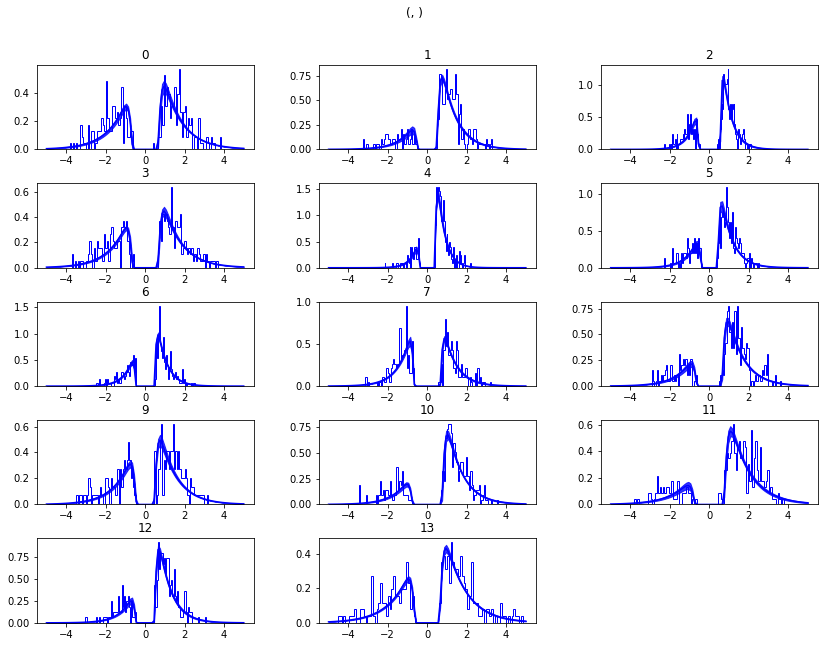

In [18]:
models_1_par[0].plot_posterior_predictive(figsize=(14, 10))

In [19]:
m_comb = kabuki.utils.concat_models(models_1_par) # combine four chains together

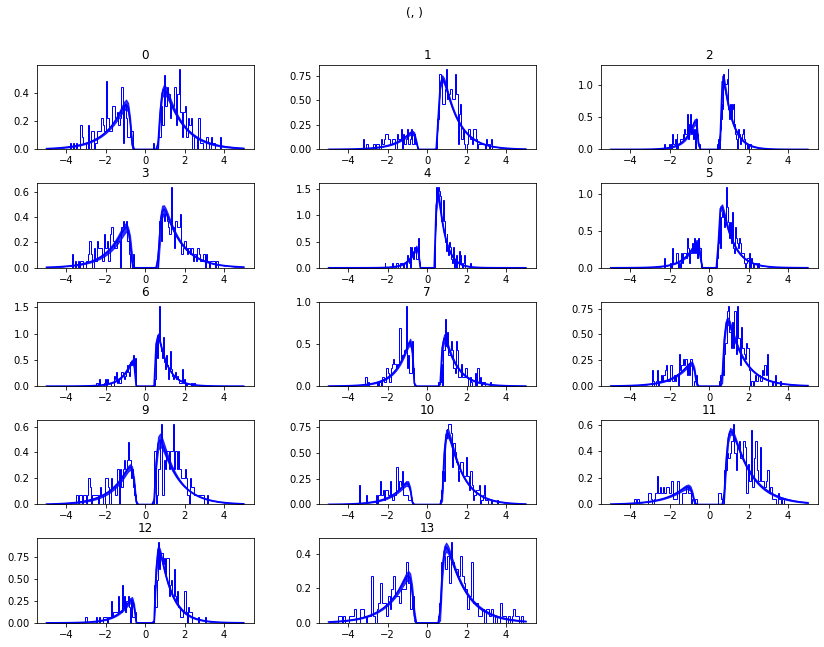

In [20]:
m_comb.plot_posterior_predictive(figsize=(14, 10))

### Model 2: `v` depends on stimulus

The original tutorial used code like this:

```
m_stim = hddm.HDDM(data, depends_on={'v': 'stim'})
m_stim.find_starting_values()
m_stim.sample(10000, burn=1000)
```

Here we defined a function for stimulus coding and used parallel processing

In [21]:
def ms2(id, data=None, samples=None, burn=None, save_name="cavanagh2011_m2"): 

    print('running model%i'%id);
    
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    
    m = hddm.HDDM(data, depends_on={'v': 'stim'})
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # save the model data
    m.save(mname)
    
    return m

In [22]:
%%time
# note: the samples, burn, and chains can be changed too
models_2 = p_map(partial(ms2, data=data, samples=samples, burn=burn),
                 range(chains))

  0%|          | 0/5 [00:00<?, ?it/s]

running model0
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model1
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model2
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model3
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
running model4
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm


/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  0%                  ] 6 of 5000 complete in 0.5 sec[                  0%                  ] 6 of 5000 complete in 0.5 sec[                  0%                  ] 6 of 5000 complete in 0.6 sec[                  0%                  ] 6 of 5000 complete in 0.6 sec[                  0%                  ] 6 of 5000 complete in 0.6 sec[                  0%                  ] 11 of 5000 complete in 1.1 sec[                  0%                  ] 11 of 5000 complete in 1.0 sec[                  0%                  ] 11 of 5000 complete in 1.1 sec[                  0%                  ] 11 of 5000 complete in 1.1 sec[                  0%                  ] 11 of 5000 complete in 1.1 sec[                  0%                  ] 16 of 5000 complete in 1.5 sec[                  0%                  ] 16 of 5000 complete in 1.6 sec[                  0%                  ] 16 of 5000 complete in 1.6 sec[                  0%                  ] 16 of 5000 complete in 1.7 sec[         

 -                 3%                  ] 191 of 5000 complete in 20.7 secc[                  2%                  ] 121 of 5000 complete in 13.1 sec[                  2%                  ] 121 of 5000 complete in 13.1 sec[                  2%                  ] 121 of 5000 complete in 13.2 sec[                  2%                  ] 121 of 5000 complete in 13.3 sec[                  2%                  ] 126 of 5000 complete in 13.5 sec[                  2%                  ] 126 of 5000 complete in 13.6 sec[                  2%                  ] 126 of 5000 complete in 13.7 sec[                  2%                  ] 126 of 5000 complete in 13.7 sec[                  2%                  ] 126 of 5000 complete in 13.8 sec[                  2%                  ] 131 of 5000 complete in 14.0 sec[                  2%                  ] 131 of 5000 complete in 14.2 sec[                  2%                  ] 131 of 5000 complete in 14.2 sec[                  2%                  ] 131 of 50

 [-                 4%                  ] 231 of 5000 complete in 25.3 sec[-                 4%                  ] 236 of 5000 complete in 25.7 sec[-                 4%                  ] 236 of 5000 complete in 25.7 sec[-                 4%                  ] 236 of 5000 complete in 25.8 sec[-                 4%                  ] 236 of 5000 complete in 25.9 sec[-                 4%                  ] 236 of 5000 complete in 25.9 sec[-                 4%                  ] 241 of 5000 complete in 26.2 sec[-                 4%                  ] 241 of 5000 complete in 26.2 sec[-                 4%                  ] 241 of 5000 complete in 26.3 sec  [-                 4%                  ] 241 of 5000 complete in 26.4 sec[-                 4%                  ] 241 of 5000 complete in 26.4 sec[-                 4%                  ] 246 of 5000 complete in 26.7 sec[-                 4%                  ] 246 of 5000 complete in 26.8 sec[-                 4%                  ] 246 of 

 [--                6%                  ] 346 of 5000 complete in 37.8 sec[--                6%                  ] 345 of 5000 complete in 38.0 sec[--                6%                  ] 346 of 5000 complete in 38.0 sec[--                7%                  ] 351 of 5000 complete in 38.2 sec[--                7%                  ] 350 of 5000 complete in 38.2 sec[--                7%                  ] 351 of 5000 complete in 38.3 sec[--                7%                  ] 350 of 5000 complete in 38.5 sec[--                7%                  ] 351 of 5000 complete in 38.5 sec[--                7%                  ] 356 of 5000 complete in 38.7 sec[--                7%                  ] 355 of 5000 complete in 38.8 sec[--                7%                  ] 356 of 5000 complete in 38.8 sec[--                7%                  ] 355 of 5000 complete in 39.1 sec[--                7%                  ] 356 of 5000 complete in 39.0 sec[--                7%                  ] 361 of 50

 [---               9%                  ] 455 of 5000 complete in 50.1 sec[---               9%                  ] 461 of 5000 complete in 50.2 sec[---               9%                  ] 461 of 5000 complete in 50.3 sec[---               9%                  ] 465 of 5000 complete in 50.6 sec[---               9%                  ] 461 of 5000 complete in 50.5 sec[---               9%                  ] 460 of 5000 complete in 50.6 sec[---               9%                  ] 466 of 5000 complete in 50.7 sec[---               9%                  ] 466 of 5000 complete in 50.8 sec[---               9%                  ] 470 of 5000 complete in 51.2 sec[---               9%                  ] 465 of 5000 complete in 51.1 sec[---               9%                  ] 466 of 5000 complete in 51.1 sec[---               9%                  ] 471 of 5000 complete in 51.3 sec[---               9%                  ] 471 of 5000 complete in 51.4 sec[---               9%                  ] 475 of 50

 ----             13%                  ] 652 of 5000 complete in 71.0 secc[----             11%                  ] 570 of 5000 complete in 62.7 sec[----             11%                  ] 576 of 5000 complete in 62.8 sec[----             11%                  ] 575 of 5000 complete in 62.9 sec[----             11%                  ] 577 of 5000 complete in 62.9 sec[----             11%                  ] 576 of 5000 complete in 63.1 sec[----             11%                  ] 575 of 5000 complete in 63.2 sec[----             11%                  ] 581 of 5000 complete in 63.3 sec[----             11%                  ] 582 of 5000 complete in 63.4 sec[----             11%                  ] 580 of 5000 complete in 63.5 sec[----             11%                  ] 581 of 5000 complete in 63.6 sec[----             11%                  ] 580 of 5000 complete in 63.8 sec[----             11%                  ] 586 of 5000 complete in 63.8 sec[----             11%                  ] 587 of 50

 -----            13%                  ] 696 of 5000 complete in 75.9 secc[-----            13%                  ] 686 of 5000 complete in 75.2 sec[-----            13%                  ] 685 of 5000 complete in 75.3 sec[-----            13%                  ] 691 of 5000 complete in 75.3 sec[-----            13%                  ] 690 of 5000 complete in 75.4 sec[-----            13%                  ] 692 of 5000 complete in 75.4 sec[-----            13%                  ] 691 of 5000 complete in 75.7 sec[-----            13%                  ] 690 of 5000 complete in 75.8 sec [-----            13%                  ] 695 of 5000 complete in 75.9 sec[-----            13%                  ] 697 of 5000 complete in 75.9 sec[-----            13%                  ] 696 of 5000 complete in 76.3 sec[-----            13%                  ] 695 of 5000 complete in 76.4 sec[-----            14%                  ] 700 of 5000 complete in 76.5 sec[-----            14%                  ] 701 of 5

 [------           15%                  ] 796 of 5000 complete in 87.4 sec[------           16%                  ] 800 of 5000 complete in 87.6 sec[------           16%                  ] 800 of 5000 complete in 87.8 sec[------           16%                  ] 807 of 5000 complete in 87.9 sec[------           16%                  ] 806 of 5000 complete in 87.9 sec[------           16%                  ] 801 of 5000 complete in 87.9 sec[------           16%                  ] 805 of 5000 complete in 88.1 sec[------           16%                  ] 805 of 5000 complete in 88.4 sec[------           16%                  ] 811 of 5000 complete in 88.5 sec[------           16%                  ] 813 of 5000 complete in 88.5 sec[------           16%                  ] 806 of 5000 complete in 88.4 sec[------           16%                  ] 810 of 5000 complete in 88.6 sec[------           16%                  ] 810 of 5000 complete in 88.9 sec[------           16%                  ] 816 of 50

 [------           18%                  ] 910 of 5000 complete in 100.0 sec[------           18%                  ] 916 of 5000 complete in 100.0 sec[------           18%                  ] 911 of 5000 complete in 100.0 sec[------           18%                  ] 915 of 5000 complete in 100.2 sec[-------          18%                  ] 923 of 5000 complete in 100.5 sec[------           18%                  ] 915 of 5000 complete in 100.5 sec[------           18%                  ] 921 of 5000 complete in 100.6 sec[------           18%                  ] 916 of 5000 complete in 100.6 sec[------           18%                  ] 920 of 5000 complete in 100.8 sec[------           18%                  ] 920 of 5000 complete in 101.0 sec[-------          18%                  ] 928 of 5000 complete in 101.1 sec[-------          18%                  ] 926 of 5000 complete in 101.1 sec[------           18%                  ] 921 of 5000 complete in 101.1 sec[-------          18%                

 [-------          20%                  ] 1028 of 5000 complete in 112.1 sec[-------          20%                  ] 1026 of 5000 complete in 112.2 sec[-------          20%                  ] 1025 of 5000 complete in 112.4 sec[-------          20%                  ] 1025 of 5000 complete in 112.5 sec[-------          20%                  ] 1026 of 5000 complete in 112.6 sec[-------          20%                  ] 1033 of 5000 complete in 112.7 sec[-------          20%                  ] 1031 of 5000 complete in 112.7 sec[-------          20%                  ] 1030 of 5000 complete in 113.0 sec[-------          20%                  ] 1030 of 5000 complete in 113.0 sec[-------          20%                  ] 1031 of 5000 complete in 113.1 sec[-------          20%                  ] 1038 of 5000 complete in 113.2 sec[-------          20%                  ] 1036 of 5000 complete in 113.2 sec[-------          20%                  ] 1035 of 5000 complete in 113.6 sec[-------          20%   

 ---------        24%                  ] 1210 of 5000 complete in 132.8 secc[--------         22%                  ] 1136 of 5000 complete in 124.2 sec[--------         22%                  ] 1135 of 5000 complete in 124.5 sec[--------         22%                  ] 1143 of 5000 complete in 124.6 sec[--------         22%                  ] 1135 of 5000 complete in 124.6 sec[--------         22%                  ] 1136 of 5000 complete in 124.6 sec[--------         22%                  ] 1141 of 5000 complete in 124.7 sec[--------         22%                  ] 1140 of 5000 complete in 125.1 sec[--------         22%                  ] 1148 of 5000 complete in 125.1 sec[--------         22%                  ] 1140 of 5000 complete in 125.2 sec[--------         22%                  ] 1141 of 5000 complete in 125.2 sec[--------         22%                  ] 1146 of 5000 complete in 125.3 sec[--------         22%                  ] 1145 of 5000 complete in 125.6 sec[--------         23%   

 ----------       26%                  ] 1343 of 5000 complete in 147.7 secc[---------        24%                  ] 1245 of 5000 complete in 136.7 sec[---------        25%                  ] 1253 of 5000 complete in 136.7 sec[---------        24%                  ] 1246 of 5000 complete in 136.7 sec[---------        24%                  ] 1245 of 5000 complete in 136.8 sec[---------        25%                  ] 1251 of 5000 complete in 137.0 sec[---------        25%                  ] 1250 of 5000 complete in 137.2 sec[---------        25%                  ] 1258 of 5000 complete in 137.3 sec[---------        25%                  ] 1251 of 5000 complete in 137.2 sec[---------        25%                  ] 1250 of 5000 complete in 137.4 sec[---------        25%                  ] 1256 of 5000 complete in 137.6 sec[---------        25%                  ] 1255 of 5000 complete in 137.8 sec[---------        25%                  ] 1263 of 5000 complete in 137.9 sec[---------        25%   

 [----------       27%                  ] 1359 of 5000 complete in 148.7 sec[----------       27%                  ] 1353 of 5000 complete in 148.7 sec[----------       27%                  ] 1353 of 5000 complete in 148.8 sec[----------       27%                  ] 1353 of 5000 complete in 148.9 sec[----------       27%                  ] 1357 of 5000 complete in 149.1 sec[----------       27%                  ] 1364 of 5000 complete in 149.2 sec[----------       27%                  ] 1358 of 5000 complete in 149.2 sec[----------       27%                  ] 1358 of 5000 complete in 149.4 sec[----------       27%                  ] 1358 of 5000 complete in 149.5 sec[----------       27%                  ] 1362 of 5000 complete in 149.6 sec[----------       27%                  ] 1369 of 5000 complete in 149.8 sec[----------       27%                  ] 1363 of 5000 complete in 149.7 sec[----------       27%                  ] 1363 of 5000 complete in 149.9 sec[----------       27%   

 -----------      30%                  ] 1543 of 5000 complete in 169.5 secc[-----------      29%                  ] 1463 of 5000 complete in 160.7 sec[-----------      29%                  ] 1462 of 5000 complete in 160.7 sec[-----------      29%                  ] 1463 of 5000 complete in 160.9 sec[-----------      29%                  ] 1468 of 5000 complete in 161.1 sec[-----------      29%                  ] 1468 of 5000 complete in 161.3 sec[-----------      29%                  ] 1467 of 5000 complete in 161.2 sec[-----------      29%                  ] 1474 of 5000 complete in 161.3 sec[-----------      29%                  ] 1468 of 5000 complete in 161.4 sec[-----------      29%                  ] 1473 of 5000 complete in 161.7 sec[-----------      29%                  ] 1473 of 5000 complete in 161.8 sec[-----------      29%                  ] 1472 of 5000 complete in 161.8 sec[-----------      29%                  ] 1479 of 5000 complete in 161.8 sec[-----------      29%   

 [-----------      31%                  ] 1573 of 5000 complete in 172.8 sec[------------     31%                  ] 1579 of 5000 complete in 173.0 sec[-----------      31%                  ] 1573 of 5000 complete in 173.0 sec[-----------      31%                  ] 1578 of 5000 complete in 173.1 sec[-----------      31%                  ] 1577 of 5000 complete in 173.2 sec[-----------      31%                  ] 1578 of 5000 complete in 173.4 sec[------------     31%                  ] 1584 of 5000 complete in 173.5 sec[-----------      31%                  ] 1578 of 5000 complete in 173.5 sec[------------     31%                  ] 1583 of 5000 complete in 173.7 sec[------------     31%                  ] 1582 of 5000 complete in 173.8 sec[------------     31%                  ] 1583 of 5000 complete in 173.9 sec[------------     31%                  ] 1589 of 5000 complete in 174.1 sec[------------     31%                  ] 1583 of 5000 complete in 174.1 sec  [------------     31% 

 -------------    34%                  ] 1748 of 5000 complete in 192.3 secc[------------     33%                  ] 1688 of 5000 complete in 185.1 sec[------------     33%                  ] 1683 of 5000 complete in 185.2 sec[------------     33%                  ] 1688 of 5000 complete in 185.3 sec[------------     33%                  ] 1688 of 5000 complete in 185.2 sec[------------     33%                  ] 1687 of 5000 complete in 185.3 sec[------------     33%                  ] 1693 of 5000 complete in 185.6 sec[------------     33%                  ] 1688 of 5000 complete in 185.7 sec[------------     33%                  ] 1693 of 5000 complete in 185.8 sec[------------     33%                  ] 1692 of 5000 complete in 185.8 sec[------------     33%                  ] 1693 of 5000 complete in 185.8 sec[------------     33%                  ] 1698 of 5000 complete in 186.2 sec[------------     33%                  ] 1693 of 5000 complete in 186.3 sec[------------     33%   

 [-------------    35%                  ] 1797 of 5000 complete in 197.2 sec[-------------    35%                  ] 1799 of 5000 complete in 197.3 sec[-------------    35%                  ] 1793 of 5000 complete in 197.3 sec[-------------    35%                  ] 1798 of 5000 complete in 197.5 sec[-------------    35%                  ] 1798 of 5000 complete in 197.4 sec[-------------    36%                  ] 1802 of 5000 complete in 197.8 sec[-------------    35%                  ] 1798 of 5000 complete in 197.8 sec[-------------    36%                  ] 1804 of 5000 complete in 197.9 sec[-------------    36%                  ] 1803 of 5000 complete in 198.0 sec[-------------    36%                  ] 1803 of 5000 complete in 197.9 sec[-------------    36%                  ] 1807 of 5000 complete in 198.3 sec[-------------    36%                  ] 1809 of 5000 complete in 198.4 sec[-------------    36%                  ] 1803 of 5000 complete in 198.4 sec[-------------    36%   

 [--------------   38%                  ] 1909 of 5000 complete in 209.4 sec[--------------   38%                  ] 1907 of 5000 complete in 209.4 sec[--------------   38%                  ] 1903 of 5000 complete in 209.4 sec[--------------   38%                  ] 1908 of 5000 complete in 209.5 sec[--------------   38%                  ] 1909 of 5000 complete in 209.6 sec[--------------   38%                  ] 1914 of 5000 complete in 210.0 sec[--------------   38%                  ] 1912 of 5000 complete in 209.9 sec[--------------   38%                  ] 1908 of 5000 complete in 210.0 sec[--------------   38%                  ] 1913 of 5000 complete in 210.0 sec[--------------   38%                  ] 1914 of 5000 complete in 210.2 sec[--------------   38%                  ] 1919 of 5000 complete in 210.5 sec[--------------   38%                  ] 1917 of 5000 complete in 210.5 sec[--------------   38%                  ] 1913 of 5000 complete in 210.5 sec[--------------   38%   

 [---------------  40%                  ] 2013 of 5000 complete in 221.3 sec[---------------  40%                  ] 2017 of 5000 complete in 221.4 sec[---------------  40%                  ] 2019 of 5000 complete in 221.5 sec[---------------  40%                  ] 2019 of 5000 complete in 221.6 sec[---------------  40%                  ] 2018 of 5000 complete in 221.8 sec[---------------  40%                  ] 2018 of 5000 complete in 221.8 sec[---------------  40%                  ] 2022 of 5000 complete in 222.0 sec[---------------  40%                  ] 2024 of 5000 complete in 222.0 sec[---------------  40%                  ] 2024 of 5000 complete in 222.1 sec[---------------  40%                  ] 2023 of 5000 complete in 222.4 sec[---------------  40%                  ] 2023 of 5000 complete in 222.3 sec[---------------  40%                  ] 2027 of 5000 complete in 222.5 sec[---------------  40%                  ] 2029 of 5000 complete in 222.6 sec[---------------  40%   

 ---------------- 42%                  ] 2142 of 5000 complete in 235.1 secc[---------------- 42%                  ] 2127 of 5000 complete in 233.4 sec[---------------- 42%                  ] 2129 of 5000 complete in 233.5 sec[---------------- 42%                  ] 2129 of 5000 complete in 233.6 sec[---------------- 42%                  ] 2128 of 5000 complete in 233.7 sec[---------------- 42%                  ] 2129 of 5000 complete in 233.8 sec[---------------- 42%                  ] 2132 of 5000 complete in 233.9 sec[---------------- 42%                  ] 2134 of 5000 complete in 234.0 sec[---------------- 42%                  ] 2134 of 5000 complete in 234.1 sec[---------------- 42%                  ] 2133 of 5000 complete in 234.2 sec[---------------- 42%                  ] 2134 of 5000 complete in 234.4 sec[---------------- 42%                  ] 2137 of 5000 complete in 234.5 sec[---------------- 42%                  ] 2139 of 5000 complete in 234.6 sec[---------------- 42%   

 -----------------46%                  ] 2328 of 5000 complete in 255.6 secc[-----------------44%                  ] 2239 of 5000 complete in 245.3 sec[---------------- 44%                  ] 2234 of 5000 complete in 245.4 sec[-----------------44%                  ] 2244 of 5000 complete in 245.9 sec[-----------------44%                  ] 2238 of 5000 complete in 245.8 sec[-----------------44%                  ] 2242 of 5000 complete in 245.8 sec[-----------------44%                  ] 2244 of 5000 complete in 245.9 sec[-----------------44%                  ] 2239 of 5000 complete in 245.9 sec[-----------------44%                  ] 2249 of 5000 complete in 246.4 sec[-----------------44%                  ] 2243 of 5000 complete in 246.3 sec[-----------------44%                  ] 2247 of 5000 complete in 246.4 sec[-----------------44%                  ] 2249 of 5000 complete in 246.4 sec[-----------------44%                  ] 2244 of 5000 complete in 246.5 sec[-----------------45%   

 [-----------------46%                  ] 2344 of 5000 complete in 257.4 sec[-----------------47%                  ] 2351 of 5000 complete in 257.7 sec[-----------------47%                  ] 2354 of 5000 complete in 257.7 sec[-----------------47%                  ] 2353 of 5000 complete in 257.9 sec[-----------------46%                  ] 2348 of 5000 complete in 257.8 sec[-----------------46%                  ] 2349 of 5000 complete in 257.9 sec[-----------------47%                  ] 2356 of 5000 complete in 258.2 sec[-----------------47%                  ] 2359 of 5000 complete in 258.3 sec[-----------------47%                  ] 2358 of 5000 complete in 258.4 sec[-----------------47%                  ] 2353 of 5000 complete in 258.3 sec[-----------------47%                  ] 2354 of 5000 complete in 258.5 sec[-----------------47%                  ] 2361 of 5000 complete in 258.7 sec[-----------------47%                  ] 2364 of 5000 complete in 258.8 sec[-----------------47%   

 [-----------------49%                  ] 2460 of 5000 complete in 269.4 sec[-----------------49%                  ] 2454 of 5000 complete in 269.4 sec[-----------------49%                  ] 2458 of 5000 complete in 269.6 sec[-----------------49%                  ] 2466 of 5000 complete in 269.7 sec[-----------------49%                  ] 2464 of 5000 complete in 269.8 sec[-----------------49%                  ] 2465 of 5000 complete in 269.9 sec[-----------------49%                  ] 2459 of 5000 complete in 269.9 sec[-----------------49%                  ] 2463 of 5000 complete in 270.1 sec[-----------------49%                  ] 2469 of 5000 complete in 270.3 sec[-----------------49%                  ] 2471 of 5000 complete in 270.3 sec[-----------------49%                  ] 2464 of 5000 complete in 270.5 sec[-----------------49%                  ] 2470 of 5000 complete in 270.5 sec[-----------------49%                  ] 2468 of 5000 complete in 270.6 sec[-----------------49%   

 -----------------53%                  ] 2666 of 5000 complete in 292.0 secc[-----------------51%                  ] 2571 of 5000 complete in 281.5 sec[-----------------51%                  ] 2576 of 5000 complete in 281.6 sec[-----------------51%                  ] 2574 of 5000 complete in 281.8 sec[-----------------51%                  ] 2568 of 5000 complete in 281.8 sec[-----------------51%                  ] 2569 of 5000 complete in 281.9 sec[-----------------51%                  ] 2576 of 5000 complete in 282.1 sec[-----------------51%                  ] 2581 of 5000 complete in 282.1 sec[-----------------51%                  ] 2579 of 5000 complete in 282.3 sec[-----------------51%                  ] 2573 of 5000 complete in 282.3 sec[-----------------51%                  ] 2574 of 5000 complete in 282.4 sec[-----------------51%                  ] 2581 of 5000 complete in 282.6 sec[-----------------51%                  ] 2586 of 5000 complete in 282.6 sec[-----------------51%   

 [-----------------53%                  ] 2681 of 5000 complete in 293.6 sec[-----------------53%                  ] 2688 of 5000 complete in 293.6 sec[-----------------53%                  ] 2684 of 5000 complete in 293.7 sec[-----------------53%                  ] 2678 of 5000 complete in 293.7 sec[-----------------53%                  ] 2680 of 5000 complete in 293.8 sec[-----------------53%                  ] 2686 of 5000 complete in 294.1 sec[-----------------53%                  ] 2693 of 5000 complete in 294.2 sec[-----------------53%                  ] 2689 of 5000 complete in 294.3 sec[-----------------53%                  ] 2683 of 5000 complete in 294.2 sec[-----------------53%                  ] 2685 of 5000 complete in 294.4 sec[-----------------53%                  ] 2691 of 5000 complete in 294.6 sec[-----------------53%                  ] 2698 of 5000 complete in 294.7 sec[-----------------53%                  ] 2694 of 5000 complete in 294.8 sec[-----------------53%   

 -----------------55%-                 ] 2788 of 5000 complete in 305.6 secc[-----------------55%-                 ] 2791 of 5000 complete in 305.6 sec [-----------------55%-                 ] 2790 of 5000 complete in 305.7 sec[-----------------55%-                 ] 2794 of 5000 complete in 305.9 sec[-----------------56%-                 ] 2805 of 5000 complete in 306.0 sec[-----------------55%-                 ] 2796 of 5000 complete in 306.2 sec[-----------------55%-                 ] 2793 of 5000 complete in 306.1 sec[-----------------55%-                 ] 2795 of 5000 complete in 306.2 sec[-----------------55%-                 ] 2799 of 5000 complete in 306.4 sec[-----------------56%-                 ] 2810 of 5000 complete in 306.6 sec[-----------------56%-                 ] 2801 of 5000 complete in 306.7 sec[-----------------55%-                 ] 2798 of 5000 complete in 306.7 sec[-----------------56%-                 ] 2800 of 5000 complete in 306.8 sec[-----------------56%- 

 [-----------------58%--                ] 2901 of 5000 complete in 317.7 sec[-----------------57%--                ] 2898 of 5000 complete in 317.7 sec[-----------------58%--                ] 2904 of 5000 complete in 317.9 sec[-----------------58%--                ] 2900 of 5000 complete in 317.9 sec[-----------------58%--                ] 2915 of 5000 complete in 318.0 sec[-----------------58%--                ] 2906 of 5000 complete in 318.2 sec[-----------------58%--                ] 2903 of 5000 complete in 318.2 sec[-----------------58%--                ] 2909 of 5000 complete in 318.5 sec[-----------------58%--                ] 2905 of 5000 complete in 318.5 sec[-----------------58%--                ] 2920 of 5000 complete in 318.6 sec[-----------------58%--                ] 2911 of 5000 complete in 318.7 sec[-----------------58%--                ] 2908 of 5000 complete in 318.8 sec[-----------------58%--                ] 2914 of 5000 complete in 319.0 sec[-----------------58%-- 

 [-----------------60%--                ] 3011 of 5000 complete in 329.7 sec[-----------------60%--                ] 3008 of 5000 complete in 329.7 sec[-----------------60%--                ] 3014 of 5000 complete in 330.0 sec[-----------------60%--                ] 3010 of 5000 complete in 329.9 sec[-----------------60%--                ] 3025 of 5000 complete in 330.2 sec[-----------------60%--                ] 3016 of 5000 complete in 330.2 sec[-----------------60%--                ] 3013 of 5000 complete in 330.3 sec[-----------------60%--                ] 3019 of 5000 complete in 330.5 sec[-----------------60%--                ] 3015 of 5000 complete in 330.5 sec[-----------------60%---               ] 3030 of 5000 complete in 330.7 sec[-----------------60%--                ] 3021 of 5000 complete in 330.8 sec[-----------------60%--                ] 3018 of 5000 complete in 330.8 sec[-----------------60%--                ] 3024 of 5000 complete in 331.0 sec[-----------------60%-- 

 [-----------------62%---               ] 3121 of 5000 complete in 341.7 sec[-----------------62%---               ] 3124 of 5000 complete in 341.9 sec[-----------------62%---               ] 3135 of 5000 complete in 341.9 sec[-----------------62%---               ] 3120 of 5000 complete in 341.9 sec[-----------------62%---               ] 3126 of 5000 complete in 342.2 sec[-----------------62%---               ] 3118 of 5000 complete in 342.2 sec[-----------------62%---               ] 3129 of 5000 complete in 342.4 sec[-----------------62%---               ] 3140 of 5000 complete in 342.4 sec[-----------------62%---               ] 3125 of 5000 complete in 342.4 sec[-----------------62%---               ] 3123 of 5000 complete in 342.7 sec[-----------------62%---               ] 3131 of 5000 complete in 342.8 sec[-----------------62%---               ] 3134 of 5000 complete in 342.9 sec[-----------------62%---               ] 3145 of 5000 complete in 343.0 sec[-----------------62%---

 [-----------------64%----              ] 3245 of 5000 complete in 353.8 sec[-----------------64%----              ] 3231 of 5000 complete in 353.8 sec[-----------------64%----              ] 3223 of 5000 complete in 353.8 sec[-----------------64%----              ] 3230 of 5000 complete in 354.0 sec[-----------------64%----              ] 3239 of 5000 complete in 354.3 sec[-----------------65%----              ] 3250 of 5000 complete in 354.3 sec[-----------------64%----              ] 3236 of 5000 complete in 354.3 sec[-----------------64%----              ] 3228 of 5000 complete in 354.3 sec[-----------------64%----              ] 3235 of 5000 complete in 354.5 sec[-----------------64%----              ] 3244 of 5000 complete in 354.8 sec[-----------------65%----              ] 3255 of 5000 complete in 354.8 sec[-----------------64%----              ] 3241 of 5000 complete in 354.8 sec[-----------------64%----              ] 3233 of 5000 complete in 354.9 sec[-----------------64%---

 [-----------------66%-----             ] 3340 of 5000 complete in 365.8 sec[-----------------66%-----             ] 3340 of 5000 complete in 365.9 sec[-----------------67%-----             ] 3354 of 5000 complete in 365.9 sec[-----------------66%-----             ] 3333 of 5000 complete in 365.9 sec[-----------------66%-----             ] 3349 of 5000 complete in 366.2 sec[-----------------67%-----             ] 3359 of 5000 complete in 366.4 sec[-----------------66%-----             ] 3345 of 5000 complete in 366.4 sec[-----------------66%-----             ] 3345 of 5000 complete in 366.4 sec[-----------------66%-----             ] 3338 of 5000 complete in 366.4 sec[-----------------67%-----             ] 3354 of 5000 complete in 366.8 sec[-----------------67%-----             ] 3350 of 5000 complete in 366.9 sec[-----------------67%-----             ] 3364 of 5000 complete in 367.0 sec[-----------------67%-----             ] 3350 of 5000 complete in 367.0 sec[-----------------66%---

 [-----------------69%------            ] 3454 of 5000 complete in 377.7 sec[-----------------69%------            ] 3450 of 5000 complete in 377.8 sec[-----------------69%------            ] 3450 of 5000 complete in 377.9 sec[-----------------68%------            ] 3443 of 5000 complete in 378.1 sec[-----------------69%------            ] 3459 of 5000 complete in 378.2 sec[-----------------69%------            ] 3469 of 5000 complete in 378.2 sec[-----------------69%------            ] 3455 of 5000 complete in 378.3 sec[-----------------69%------            ] 3455 of 5000 complete in 378.4 sec[-----------------69%------            ] 3464 of 5000 complete in 378.8 sec[-----------------68%------            ] 3448 of 5000 complete in 378.6 sec[-----------------69%------            ] 3474 of 5000 complete in 378.8 sec[-----------------69%------            ] 3460 of 5000 complete in 378.8 sec[-----------------69%------            ] 3460 of 5000 complete in 378.9 sec[-----------------69%---

 [-----------------71%-------           ] 3559 of 5000 complete in 389.7 sec[-----------------70%------            ] 3549 of 5000 complete in 389.7 sec[-----------------71%-------           ] 3561 of 5000 complete in 389.9 sec[-----------------71%-------           ] 3579 of 5000 complete in 390.2 sec[-----------------71%-------           ] 3570 of 5000 complete in 390.2 sec[-----------------71%-------           ] 3564 of 5000 complete in 390.3 sec[-----------------71%-------           ] 3554 of 5000 complete in 390.2 sec[-----------------71%-------           ] 3566 of 5000 complete in 390.4 sec[-----------------71%-------           ] 3584 of 5000 complete in 390.7 sec[-----------------71%-------           ] 3575 of 5000 complete in 390.8 sec[-----------------71%-------           ] 3569 of 5000 complete in 390.8 sec[-----------------71%-------           ] 3559 of 5000 complete in 390.8 sec[-----------------71%-------           ] 3571 of 5000 complete in 390.9 sec[-----------------71%---

 [-----------------73%-------           ] 3669 of 5000 complete in 401.8 sec[-----------------73%-------           ] 3671 of 5000 complete in 401.8 sec[-----------------73%-------           ] 3659 of 5000 complete in 402.0 sec[-----------------73%--------          ] 3689 of 5000 complete in 402.1 sec[-----------------73%-------           ] 3681 of 5000 complete in 402.2 sec[-----------------73%-------           ] 3674 of 5000 complete in 402.3 sec[-----------------73%-------           ] 3676 of 5000 complete in 402.4 sec[-----------------73%-------           ] 3664 of 5000 complete in 402.5 sec[-----------------73%--------          ] 3694 of 5000 complete in 402.7 sec[-----------------73%--------          ] 3686 of 5000 complete in 402.8 sec[-----------------73%-------           ] 3679 of 5000 complete in 402.9 sec[-----------------73%-------           ] 3681 of 5000 complete in 402.9 sec[-----------------73%-------           ] 3669 of 5000 complete in 403.1 sec[-----------------73%---

 -----------------77%---------         ] 3851 of 5000 complete in 420.6 secc[-----------------75%--------          ] 3799 of 5000 complete in 413.9 sec[-----------------75%--------          ] 3781 of 5000 complete in 413.9 sec[-----------------75%--------          ] 3769 of 5000 complete in 413.9 sec[-----------------75%--------          ] 3791 of 5000 complete in 414.1 sec[-----------------75%--------          ] 3784 of 5000 complete in 414.1 sec[-----------------76%--------          ] 3804 of 5000 complete in 414.5 sec[-----------------75%--------          ] 3786 of 5000 complete in 414.5 sec[-----------------75%--------          ] 3796 of 5000 complete in 414.6 sec[-----------------75%--------          ] 3774 of 5000 complete in 414.5 sec[-----------------75%--------          ] 3789 of 5000 complete in 414.7 sec[-----------------76%--------          ] 3809 of 5000 complete in 415.0 sec[-----------------75%--------          ] 3791 of 5000 complete in 415.1 sec[-----------------76%---

 [-----------------77%---------         ] 3891 of 5000 complete in 425.8 sec[-----------------78%---------         ] 3909 of 5000 complete in 425.9 sec[-----------------78%---------         ] 3901 of 5000 complete in 426.0 sec[-----------------77%---------         ] 3880 of 5000 complete in 425.9 sec[-----------------77%---------         ] 3894 of 5000 complete in 426.1 sec[-----------------77%---------         ] 3896 of 5000 complete in 426.4 sec[-----------------78%---------         ] 3914 of 5000 complete in 426.5 sec[-----------------78%---------         ] 3906 of 5000 complete in 426.5 sec[-----------------77%---------         ] 3885 of 5000 complete in 426.5 sec[-----------------77%---------         ] 3899 of 5000 complete in 426.6 sec[-----------------78%---------         ] 3901 of 5000 complete in 426.9 sec[-----------------78%---------         ] 3919 of 5000 complete in 427.0 sec[-----------------78%---------         ] 3911 of 5000 complete in 427.1 sec[-----------------77%---

 [-----------------80%----------        ] 4011 of 5000 complete in 437.9 sec[-----------------80%----------        ] 4001 of 5000 complete in 437.9 sec[-----------------80%----------        ] 4019 of 5000 complete in 438.0 sec[-----------------79%----------        ] 3989 of 5000 complete in 437.9 sec[-----------------80%----------        ] 4004 of 5000 complete in 438.0 sec[-----------------80%----------        ] 4016 of 5000 complete in 438.5 sec[-----------------80%----------        ] 4006 of 5000 complete in 438.4 sec[-----------------80%----------        ] 4024 of 5000 complete in 438.5 sec[-----------------79%----------        ] 3994 of 5000 complete in 438.5 sec[-----------------80%----------        ] 4009 of 5000 complete in 438.6 sec[-----------------80%----------        ] 4021 of 5000 complete in 439.0 sec[-----------------80%----------        ] 4011 of 5000 complete in 439.0 sec[-----------------80%----------        ] 4029 of 5000 complete in 439.0 sec[-----------------79%---

 -----------------82%-----------       ] 4149 of 5000 complete in 453.9 secc[-----------------82%-----------       ] 4111 of 5000 complete in 450.0 sec  [-----------------81%-----------       ] 4099 of 5000 complete in 450.0 sec[-----------------82%-----------       ] 4114 of 5000 complete in 450.0 sec[-----------------82%-----------       ] 4130 of 5000 complete in 450.1 sec[-----------------82%-----------       ] 4126 of 5000 complete in 450.2 sec[-----------------82%-----------       ] 4116 of 5000 complete in 450.6 sec[-----------------82%-----------       ] 4104 of 5000 complete in 450.5 sec[-----------------82%-----------       ] 4119 of 5000 complete in 450.6 sec[-----------------82%-----------       ] 4135 of 5000 complete in 450.6 sec[-----------------82%-----------       ] 4131 of 5000 complete in 450.8 sec[-----------------82%-----------       ] 4121 of 5000 complete in 451.1 sec[-----------------82%-----------       ] 4109 of 5000 complete in 451.1 sec [-----------------82%

 [-----------------84%-----------       ] 4209 of 5000 complete in 462.0 sec[-----------------84%------------      ] 4221 of 5000 complete in 462.1 sec[-----------------84%------------      ] 4224 of 5000 complete in 462.2 sec[-----------------84%------------      ] 4236 of 5000 complete in 462.4 sec[-----------------84%------------      ] 4246 of 5000 complete in 462.7 sec[-----------------84%------------      ] 4226 of 5000 complete in 462.6 sec[-----------------84%------------      ] 4214 of 5000 complete in 462.6 sec[-----------------84%------------      ] 4229 of 5000 complete in 462.8 sec[-----------------84%------------      ] 4241 of 5000 complete in 462.9 sec[-----------------84%------------      ] 4231 of 5000 complete in 463.2 sec[-----------------85%------------      ] 4251 of 5000 complete in 463.2 sec[-----------------84%------------      ] 4219 of 5000 complete in 463.2 sec[-----------------84%------------      ] 4234 of 5000 complete in 463.3 sec[-----------------84%---

 [-----------------87%-------------     ] 4351 of 5000 complete in 474.1 sec[-----------------86%------------      ] 4331 of 5000 complete in 474.1 sec[-----------------86%------------      ] 4334 of 5000 complete in 474.3 sec[-----------------86%-------------     ] 4346 of 5000 complete in 474.5 sec[-----------------86%------------      ] 4324 of 5000 complete in 474.5 sec[-----------------87%-------------     ] 4356 of 5000 complete in 474.7 sec[-----------------86%------------      ] 4336 of 5000 complete in 474.7 sec[-----------------86%------------      ] 4339 of 5000 complete in 474.8 sec[-----------------87%-------------     ] 4351 of 5000 complete in 475.0 sec[-----------------86%------------      ] 4329 of 5000 complete in 475.0 sec[-----------------87%-------------     ] 4361 of 5000 complete in 475.2 sec[-----------------86%------------      ] 4341 of 5000 complete in 475.2 sec[-----------------86%-------------     ] 4344 of 5000 complete in 475.3 sec[-----------------87%---

 [-----------------88%-------------     ] 4429 of 5000 complete in 486.0 sec[-----------------88%-------------     ] 4441 of 5000 complete in 486.1 sec[-----------------88%-------------     ] 4444 of 5000 complete in 486.2 sec[-----------------89%-------------     ] 4456 of 5000 complete in 486.5 sec[-----------------89%-------------     ] 4466 of 5000 complete in 486.5 sec[-----------------88%-------------     ] 4446 of 5000 complete in 486.6 sec[-----------------88%-------------     ] 4434 of 5000 complete in 486.5 sec[-----------------88%-------------     ] 4449 of 5000 complete in 486.7 sec[-----------------89%-------------     ] 4461 of 5000 complete in 487.0 sec[-----------------89%-------------     ] 4471 of 5000 complete in 487.0 sec[-----------------88%-------------     ] 4439 of 5000 complete in 487.1 sec[-----------------89%-------------     ] 4451 of 5000 complete in 487.2 sec[-----------------89%-------------     ] 4454 of 5000 complete in 487.3 sec[-----------------89%---

 [-----------------91%--------------    ] 4554 of 5000 complete in 498.0 sec[-----------------90%--------------    ] 4539 of 5000 complete in 498.0 sec[-----------------91%--------------    ] 4551 of 5000 complete in 498.4 sec[-----------------91%--------------    ] 4577 of 5000 complete in 498.5 sec[-----------------91%--------------    ] 4566 of 5000 complete in 498.6 sec[-----------------91%--------------    ] 4559 of 5000 complete in 498.6 sec[-----------------90%--------------    ] 4544 of 5000 complete in 498.5 sec[-----------------91%--------------    ] 4556 of 5000 complete in 498.9 sec[-----------------91%--------------    ] 4582 of 5000 complete in 499.0 sec[-----------------91%--------------    ] 4571 of 5000 complete in 499.1 sec[-----------------90%--------------    ] 4549 of 5000 complete in 499.0 sec[-----------------91%--------------    ] 4564 of 5000 complete in 499.1 sec[-----------------91%--------------    ] 4561 of 5000 complete in 499.5 sec[-----------------91%---

 [-----------------93%---------------   ] 4650 of 5000 complete in 510.0 sec[-----------------93%---------------   ] 4664 of 5000 complete in 510.1 sec[-----------------93%---------------   ] 4661 of 5000 complete in 510.3 sec[-----------------93%---------------   ] 4676 of 5000 complete in 510.5 sec[-----------------93%---------------   ] 4687 of 5000 complete in 510.6 sec[-----------------93%---------------   ] 4655 of 5000 complete in 510.6 sec[-----------------93%---------------   ] 4669 of 5000 complete in 510.7 sec[-----------------93%---------------   ] 4666 of 5000 complete in 510.8 sec[-----------------93%---------------   ] 4681 of 5000 complete in 511.0 sec[-----------------93%---------------   ] 4692 of 5000 complete in 511.1 sec[-----------------93%---------------   ] 4660 of 5000 complete in 511.1 sec[-----------------93%---------------   ] 4674 of 5000 complete in 511.2 sec[-----------------93%---------------   ] 4671 of 5000 complete in 511.4 sec[-----------------93%---

 [-----------------95%----------------  ] 4771 of 5000 complete in 522.3 sec[-----------------95%----------------  ] 4774 of 5000 complete in 522.3 sec[-----------------95%----------------  ] 4760 of 5000 complete in 522.2 sec[-----------------95%----------------  ] 4797 of 5000 complete in 522.7 sec[-----------------95%----------------  ] 4786 of 5000 complete in 522.7 sec[-----------------95%----------------  ] 4776 of 5000 complete in 522.8 sec[-----------------95%----------------  ] 4765 of 5000 complete in 522.8 sec[-----------------95%----------------  ] 4780 of 5000 complete in 522.9 sec[-----------------96%----------------  ] 4802 of 5000 complete in 523.2 sec[-----------------95%----------------  ] 4791 of 5000 complete in 523.2 sec[-----------------95%----------------  ] 4781 of 5000 complete in 523.3 sec[-----------------95%----------------  ] 4770 of 5000 complete in 523.3 sec[-----------------95%----------------  ] 4785 of 5000 complete in 523.4 sec[-----------------96%---

 -----------------99%----------------- ] 4990 of 5000 complete in 545.9 secc[-----------------98%----------------- ] 4907 of 5000 complete in 534.4 sec[-----------------97%----------------- ] 4881 of 5000 complete in 534.5 sec[-----------------97%----------------- ] 4870 of 5000 complete in 534.4 sec[-----------------97%----------------- ] 4896 of 5000 complete in 534.7 sec[-----------------97%----------------- ] 4890 of 5000 complete in 534.9 sec[-----------------98%----------------- ] 4912 of 5000 complete in 535.0 sec[-----------------97%----------------- ] 4886 of 5000 complete in 535.0 sec[-----------------97%----------------- ] 4875 of 5000 complete in 535.0 sec[-----------------98%----------------- ] 4901 of 5000 complete in 535.3 sec[-----------------97%----------------- ] 4895 of 5000 complete in 535.4 sec[-----------------98%----------------- ] 4917 of 5000 complete in 535.5 sec[-----------------97%----------------- ] 4891 of 5000 complete in 535.5 sec[-----------------97%---

[-----------------100%-----------------] 5000 of 5000 complete in 548.9 secc[-----------------100%-----------------] 5000 of 5000 complete in 547.1 sec[-----------------99%----------------- ] 4985 of 5000 complete in 547.2 sec [-----------------99%----------------- ] 4990 of 5000 complete in 547.7 sec[-----------------99%----------------- ] 4995 of 5000 complete in 548.3 sec[-----------------100%-----------------] 5000 of 5000 complete in 548.8 sec CPU times: user 9.73 s, sys: 2.24 s, total: 12 s
Wall time: 9min 13s


In [23]:
m_stim_all = kabuki.utils.concat_models(models_2) 

Text(0.5, 1.0, 'Posterior of drift-rate group means')

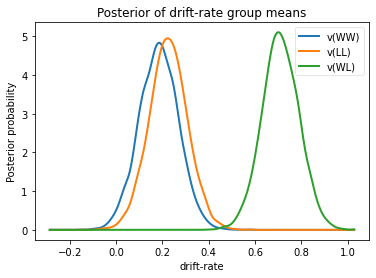

In [24]:
v_WW, v_LL, v_WL = m_stim_all.nodes_db.node[['v(WW)', 'v(LL)', 'v(WL)']]
hddm.analyze.plot_posterior_nodes([v_WW, v_LL, v_WL])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
# plt.savefig('hddm_demo_fig_06.pdf')

In [25]:
print("P(WW > LL) = ", (v_WW.trace() > v_LL.trace()).mean())
print("P(LL > WL) = ", (v_LL.trace() > v_WL.trace()).mean())

P(WW > LL) =  0.3617
P(LL > WL) =  5e-05


In [26]:
print("Lumped model DIC: %f" % m1.dic)
print("Stimulus model DIC: %f" % m_stim_all.dic)

Lumped model DIC: 10973.432616
Stimulus model DIC: 10787.302703


## Within-subject effects

In [27]:
from patsy import dmatrix
dmatrix("C(stim, Treatment('WL'))", data.head(10))

DesignMatrix with shape (10, 3)
  Intercept  C(stim, Treatment('WL'))[T.LL]  C(stim, Treatment('WL'))[T.WW]
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               0                               1
          1                               0                               0
          1                               1                               0
          1                               0                               0
          1                               0                               1
          1                               0                               0
  Terms:
    'Intercept' (column 0)
    "C(stim, Treatment('WL'))" (columns 1:3)

The original code in the tutorial was:

```
m_within_subj = hddm.HDDMRegressor(data, "v ~ C(stim, Treatment('WL'))")
m_within_subj.sample(5000, burn=200)
```

Here we used four chains for parallel processing

In [28]:
def run_m_reg(id, data=None, samples=None, burn=None, save_name="cavanagh2011_reg"): 
    
    import hddm
    
    dbname = save_name + '_chain_%i.db'%id 
    mname  = save_name + '_chain_%i'%id
    
    m = hddm.HDDMRegressor(data,
                           "v ~ C(stim, Treatment('WL'))")
    m.find_starting_values()
    m.sample(samples, burn=burn, dbname=dbname, db='pickle') # it's neccessary to save the model data
    m.save(mname)
    
    return m

In [29]:
%%time
m_reg_list = p_map(partial(run_m_reg, data=data, samples=5000, burn=1000),
                   range(chains))

No model attribute --> setting up standard HDDM
Includes supplied: 

  0%|          | 0/5 [00:00<?, ?it/s]

 ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': " C(stim, Treatment('WL'))", 'params': ['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7fe2f07acee0>}
Uses Identity Link
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': " C(stim, Treatment('WL'))", 'params': ['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7fe2f07acee0>}
Uses Identity Link
No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'v', 'model': " C(stim, Treatment('WL'))", 'params': ['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7fe2f07acee0>}No model attribute 

/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.8/site-packages/scipy/optimize/optimize.py:1985: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


 [                  1%                  ] 64 of 5000 complete in 15.7 sec[                  1%                  ] 66 of 5000 complete in 15.9 sec[                  1%                  ] 66 of 5000 complete in 15.9 sec[                  1%                  ] 67 of 5000 complete in 16.1 sec[                  1%                  ] 66 of 5000 complete in 16.3 sec[                  1%                  ] 67 of 5000 complete in 16.3 sec[                  1%                  ] 68 of 5000 complete in 16.4 sec[                  1%                  ] 69 of 5000 complete in 16.6 sec[                  1%                  ] 69 of 5000 complete in 16.6 sec[                  1%                  ] 68 of 5000 complete in 16.8 sec[                  1%                  ] 70 of 5000 complete in 17.1 sec[                  1%                  ] 71 of 5000 complete in 17.3 sec[                  1%                  ] 71 of 5000 complete in 17.3 sec[                  1%                  ] 71 of 5000 complete in

 [                  2%                  ] 125 of 5000 complete in 30.7 sec[                  2%                  ] 127 of 5000 complete in 30.7 sec[                  2%                  ] 127 of 5000 complete in 30.9 sec[                  2%                  ] 128 of 5000 complete in 31.2 sec[                  2%                  ] 127 of 5000 complete in 31.2 sec[                  2%                  ] 126 of 5000 complete in 31.5 sec[                  2%                  ] 130 of 5000 complete in 31.5 sec[                  2%                  ] 130 of 5000 complete in 31.7 sec[                  2%                  ] 130 of 5000 complete in 31.8 sec[                  2%                  ] 130 of 5000 complete in 31.8 sec[                  2%                  ] 129 of 5000 complete in 32.2 sec[-                 2%                  ] 132 of 5000 complete in 32.3 sec[-                 2%                  ] 133 of 5000 complete in 32.2 sec[-                 2%                  ] 132 of 50

 [-                 3%                  ] 188 of 5000 complete in 45.7 sec[-                 3%                  ] 190 of 5000 complete in 46.0 sec[-                 3%                  ] 190 of 5000 complete in 45.9 sec[-                 3%                  ] 190 of 5000 complete in 46.3 sec[-                 3%                  ] 191 of 5000 complete in 46.3 sec[-                 3%                  ] 187 of 5000 complete in 46.4 sec[-                 3%                  ] 193 of 5000 complete in 46.7 sec[-                 3%                  ] 193 of 5000 complete in 46.6 sec[-                 3%                  ] 193 of 5000 complete in 47.0 sec[-                 3%                  ] 190 of 5000 complete in 47.1 sec[-                 3%                  ] 194 of 5000 complete in 47.0 sec[-                 3%                  ] 196 of 5000 complete in 47.3 sec[-                 3%                  ] 196 of 5000 complete in 47.3 sec[-                 3%                  ] 196 of 50

 [-                 5%                  ] 252 of 5000 complete in 60.7 sec[-                 5%                  ] 255 of 5000 complete in 60.8 sec[-                 5%                  ] 252 of 5000 complete in 61.0 sec[-                 4%                  ] 249 of 5000 complete in 61.1 sec[-                 5%                  ] 256 of 5000 complete in 61.1 sec[-                 5%                  ] 254 of 5000 complete in 61.2 sec[-                 5%                  ] 258 of 5000 complete in 61.5 sec[-                 5%                  ] 258 of 5000 complete in 61.6 sec[-                 5%                  ] 255 of 5000 complete in 61.8 sec[-                 5%                  ] 252 of 5000 complete in 61.8 sec[-                 5%                  ] 257 of 5000 complete in 61.9 sec[-                 5%                  ] 261 of 5000 complete in 62.1 sec[-                 5%                  ] 258 of 5000 complete in 62.5 sec[-                 5%                  ] 261 of 50

 [--                6%                  ] 319 of 5000 complete in 75.7 sec[--                6%                  ] 316 of 5000 complete in 76.1 sec[--                6%                  ] 323 of 5000 complete in 76.1 sec[--                6%                  ] 313 of 5000 complete in 76.1 sec[--                6%                  ] 322 of 5000 complete in 76.3 sec[--                6%                  ] 319 of 5000 complete in 76.4 sec[--                6%                  ] 326 of 5000 complete in 76.8 sec[--                6%                  ] 319 of 5000 complete in 76.8 sec[--                6%                  ] 316 of 5000 complete in 76.8 sec[--                6%                  ] 325 of 5000 complete in 77.0 sec[--                6%                  ] 322 of 5000 complete in 77.1 sec[--                6%                  ] 329 of 5000 complete in 77.4 sec[--                6%                  ] 322 of 5000 complete in 77.5 sec[--                6%                  ] 319 of 50

 ---               8%                  ] 437 of 5000 complete in 104.6 sec[--                7%                  ] 385 of 5000 complete in 90.9 sec[--                7%                  ] 388 of 5000 complete in 91.0 sec[--                7%                  ] 380 of 5000 complete in 90.9 sec[--                7%                  ] 382 of 5000 complete in 91.6 sec[--                7%                  ] 377 of 5000 complete in 91.5 sec[--                7%                  ] 388 of 5000 complete in 91.5 sec[--                7%                  ] 391 of 5000 complete in 91.7 sec[--                7%                  ] 383 of 5000 complete in 91.6 sec [--                7%                  ] 380 of 5000 complete in 92.2 sec[--                7%                  ] 391 of 5000 complete in 92.2 sec[--                7%                  ] 394 of 5000 complete in 92.3 sec[--                7%                  ] 386 of 5000 complete in 92.4 sec[--                7%                  ] 387 of 5

 ---              10%                  ] 517 of 5000 complete in 120.7 secc[---               8%                  ] 437 of 5000 complete in 106.2 sec[---               8%                  ] 442 of 5000 complete in 106.4 sec[---               9%                  ] 454 of 5000 complete in 106.5 sec[---               9%                  ] 451 of 5000 complete in 106.5 sec[---               8%                  ] 445 of 5000 complete in 106.6 sec[---               8%                  ] 440 of 5000 complete in 106.8 sec[---               8%                  ] 445 of 5000 complete in 107.1 sec[---               9%                  ] 457 of 5000 complete in 107.1 sec[---               8%                  ] 448 of 5000 complete in 107.2 sec[---               9%                  ] 454 of 5000 complete in 107.1 sec[---               8%                  ] 443 of 5000 complete in 107.5 sec[---               8%                  ] 448 of 5000 complete in 107.8 sec[---               9%                

[----             11%                  ] 569 of 5000 complete in 135.4 secc[---              10%                  ] 504 of 5000 complete in 121.0 sec[---              10%                  ] 514 of 5000 complete in 121.1 sec[---              10%                  ] 520 of 5000 complete in 121.3 sec[---              10%                  ] 509 of 5000 complete in 121.4 sec[---              10%                  ] 502 of 5000 complete in 121.6 sec[---              10%                  ] 507 of 5000 complete in 121.7 sec[---              10%                  ] 522 of 5000 complete in 121.9 sec[---              10%                  ] 517 of 5000 complete in 121.8 sec[---              10%                  ] 512 of 5000 complete in 122.1 sec[---              10%                  ] 510 of 5000 complete in 122.4 sec[---              10%                  ] 505 of 5000 complete in 122.3 sec[---              10%                  ] 525 of 5000 complete in 122.5 sec[---              10%                

 [----             11%                  ] 563 of 5000 complete in 135.8 sec[----             11%                  ] 568 of 5000 complete in 135.9 sec[----             11%                  ] 576 of 5000 complete in 135.9 sec[----             11%                  ] 582 of 5000 complete in 136.1 sec[----             11%                  ] 572 of 5000 complete in 136.1 sec[----             11%                  ] 571 of 5000 complete in 136.5 sec[----             11%                  ] 566 of 5000 complete in 136.5 sec[----             11%                  ] 579 of 5000 complete in 136.5 sec[----             11%                  ] 585 of 5000 complete in 136.8 sec[----             11%                  ] 575 of 5000 complete in 136.8 sec[----             11%                  ] 573 of 5000 complete in 137.1 sec[----             11%                  ] 569 of 5000 complete in 137.2 sec[----             11%                  ] 582 of 5000 complete in 137.2 sec[----             11%                

 [----             12%                  ] 639 of 5000 complete in 150.3 sec[----             12%                  ] 625 of 5000 complete in 150.5 sec[----             12%                  ] 646 of 5000 complete in 150.7 sec[----             12%                  ] 630 of 5000 complete in 150.9 sec[----             12%                  ] 636 of 5000 complete in 150.9 sec[----             12%                  ] 642 of 5000 complete in 151.0 sec[----             12%                  ] 628 of 5000 complete in 151.2 sec[----             12%                  ] 649 of 5000 complete in 151.4 sec[----             12%                  ] 633 of 5000 complete in 151.7 sec[----             12%                  ] 639 of 5000 complete in 151.6 sec[----             12%                  ] 645 of 5000 complete in 151.6 sec[----             12%                  ] 631 of 5000 complete in 151.9 sec[----             13%                  ] 652 of 5000 complete in 152.0 sec[----             12%                

 -----            14%                  ] 709 of 5000 complete in 169.8 secc[-----            14%                  ] 709 of 5000 complete in 165.2 sec[-----            13%                  ] 691 of 5000 complete in 165.5 sec[-----            14%                  ] 700 of 5000 complete in 165.6 sec[-----            14%                  ] 704 of 5000 complete in 165.6 sec[-----            13%                  ] 690 of 5000 complete in 165.9 sec[-----            14%                  ] 712 of 5000 complete in 165.9 sec[-----            13%                  ] 694 of 5000 complete in 166.2 sec[-----            13%                  ] 692 of 5000 complete in 166.4 sec[-----            14%                  ] 707 of 5000 complete in 166.3 sec[-----            14%                  ] 703 of 5000 complete in 166.3 sec[-----            14%                  ] 715 of 5000 complete in 166.6 sec[-----            13%                  ] 697 of 5000 complete in 167.0 sec[-----            13%                

 [-----            15%                  ] 752 of 5000 complete in 180.1 sec[-----            15%                  ] 763 of 5000 complete in 180.2 sec[-----            15%                  ] 773 of 5000 complete in 180.3 sec[-----            15%                  ] 755 of 5000 complete in 180.5 sec[-----            15%                  ] 768 of 5000 complete in 180.5 sec[-----            15%                  ] 755 of 5000 complete in 180.8 sec[-----            15%                  ] 775 of 5000 complete in 180.8 sec[-----            15%                  ] 766 of 5000 complete in 180.9 sec[-----            15%                  ] 758 of 5000 complete in 181.2 sec[-----            15%                  ] 771 of 5000 complete in 181.2 sec[-----            15%                  ] 757 of 5000 complete in 181.3 sec[-----            15%                  ] 778 of 5000 complete in 181.5 sec[-----            15%                  ] 769 of 5000 complete in 181.6 sec[-----            15%                

 [------           16%                  ] 816 of 5000 complete in 195.0 sec[------           16%                  ] 814 of 5000 complete in 195.0 sec[------           16%                  ] 830 of 5000 complete in 194.9 sec[------           16%                  ] 826 of 5000 complete in 195.1 sec[------           16%                  ] 837 of 5000 complete in 195.1 sec[------           16%                  ] 819 of 5000 complete in 195.7 sec[------           16%                  ] 817 of 5000 complete in 195.7 sec[------           16%                  ] 833 of 5000 complete in 195.6 sec[------           16%                  ] 829 of 5000 complete in 195.7 sec[------           16%                  ] 840 of 5000 complete in 195.9 sec[------           16%                  ] 822 of 5000 complete in 196.4 sec[------           16%                  ] 820 of 5000 complete in 196.4 sec[------           16%                  ] 836 of 5000 complete in 196.3 sec[------           16%                

 [------           17%                  ] 889 of 5000 complete in 209.6 sec  [------           18%                  ] 900 of 5000 complete in 209.8 sec[------           17%                  ] 895 of 5000 complete in 209.7 sec[------           17%                  ] 879 of 5000 complete in 210.0 sec[------           17%                  ] 877 of 5000 complete in 210.0 sec[------           17%                  ] 892 of 5000 complete in 210.3 sec[------           18%                  ] 903 of 5000 complete in 210.4 sec[------           17%                  ] 898 of 5000 complete in 210.4 sec[------           17%                  ] 882 of 5000 complete in 210.7 sec[------           17%                  ] 880 of 5000 complete in 210.8 sec[------           17%                  ] 895 of 5000 complete in 211.0 sec[------           18%                  ] 906 of 5000 complete in 211.2 sec[------           18%                  ] 901 of 5000 complete in 211.1 sec[------           17%              

 [-------          19%                  ] 964 of 5000 complete in 224.7 sec[-------          18%                  ] 940 of 5000 complete in 224.9 sec[-------          19%                  ] 958 of 5000 complete in 224.8 sec[-------          19%                  ] 953 of 5000 complete in 224.9 sec[-------          18%                  ] 942 of 5000 complete in 225.4 sec[-------          18%                  ] 939 of 5000 complete in 225.4 sec[-------          19%                  ] 967 of 5000 complete in 225.4 sec[-------          19%                  ] 961 of 5000 complete in 225.5 sec[-------          19%                  ] 956 of 5000 complete in 225.5 sec[-------          18%                  ] 945 of 5000 complete in 226.1 sec[-------          19%                  ] 970 of 5000 complete in 226.1 sec[-------          18%                  ] 942 of 5000 complete in 226.1 sec[-------          19%                  ] 964 of 5000 complete in 226.1 sec[-------          19%                

 [-------          19%                  ] 998 of 5000 complete in 239.5 sec[-------          20%                  ] 1029 of 5000 complete in 239.5 sec[-------          20%                  ] 1003 of 5000 complete in 239.6 sec[-------          20%                  ] 1018 of 5000 complete in 239.7 sec[-------          20%                  ] 1000 of 5000 complete in 240.0 sec[-------          20%                  ] 1024 of 5000 complete in 239.9 sec[-------          20%                  ] 1005 of 5000 complete in 240.1 sec[-------          20%                  ] 1032 of 5000 complete in 240.3 sec[-------          20%                  ] 1021 of 5000 complete in 240.4 sec[-------          20%                  ] 1027 of 5000 complete in 240.6 sec[-------          20%                  ] 1003 of 5000 complete in 240.7 sec[-------          20%                  ] 1008 of 5000 complete in 240.9 sec[-------          20%                  ] 1035 of 5000 complete in 241.0 sec[-------          20%    

 [--------         21%                  ] 1059 of 5000 complete in 254.1 sec[--------         21%                  ] 1065 of 5000 complete in 254.1 sec[--------         21%                  ] 1086 of 5000 complete in 254.0 sec[--------         21%                  ] 1092 of 5000 complete in 254.3 sec[--------         21%                  ] 1068 of 5000 complete in 254.7 sec[--------         21%                  ] 1082 of 5000 complete in 254.6 sec[--------         21%                  ] 1062 of 5000 complete in 254.7 sec[--------         21%                  ] 1089 of 5000 complete in 254.7 sec[--------         21%                  ] 1095 of 5000 complete in 254.9 sec[--------         21%                  ] 1070 of 5000 complete in 255.3 sec[--------         21%                  ] 1085 of 5000 complete in 255.3 sec[--------         21%                  ] 1065 of 5000 complete in 255.4 sec[--------         21%                  ] 1097 of 5000 complete in 255.5 sec[--------         21%   

 --------         23%                  ] 1150 of 5000 complete in 274.1 secc[--------         22%                  ] 1142 of 5000 complete in 268.5 sec[--------         22%                  ] 1147 of 5000 complete in 268.5 sec[--------         22%                  ] 1120 of 5000 complete in 268.7 sec[--------         22%                  ] 1127 of 5000 complete in 268.8 sec[--------         23%                  ] 1156 of 5000 complete in 269.1 sec[--------         22%                  ] 1145 of 5000 complete in 269.2 sec[--------         22%                  ] 1122 of 5000 complete in 269.2 sec[--------         23%                  ] 1150 of 5000 complete in 269.2 sec[--------         22%                  ] 1129 of 5000 complete in 269.4 sec[--------         23%                  ] 1159 of 5000 complete in 269.8 sec[--------         22%                  ] 1125 of 5000 complete in 269.9 sec[--------         22%                  ] 1148 of 5000 complete in 269.9 sec[--------         22%   

 [---------        24%                  ] 1205 of 5000 complete in 283.0 sec[---------        24%                  ] 1212 of 5000 complete in 283.2 sec[---------        24%                  ] 1219 of 5000 complete in 283.5 sec[--------         23%                  ] 1182 of 5000 complete in 283.5 sec[---------        23%                  ] 1192 of 5000 complete in 283.7 sec[---------        24%                  ] 1208 of 5000 complete in 283.8 sec[---------        24%                  ] 1215 of 5000 complete in 283.8 sec[---------        24%                  ] 1221 of 5000 complete in 284.0 sec[--------         23%                  ] 1184 of 5000 complete in 284.0 sec[---------        23%                  ] 1195 of 5000 complete in 284.4 sec[---------        24%                  ] 1211 of 5000 complete in 284.5 sec[---------        24%                  ] 1218 of 5000 complete in 284.5 sec[---------        23%                  ] 1187 of 5000 complete in 284.7 sec[---------        24%   

 [---------        25%                  ] 1281 of 5000 complete in 297.7 sec[---------        25%                  ] 1269 of 5000 complete in 297.9 sec[---------        24%                  ] 1244 of 5000 complete in 298.0 sec[---------        25%                  ] 1254 of 5000 complete in 298.2 sec[---------        25%                  ] 1277 of 5000 complete in 298.2 sec[---------        25%                  ] 1284 of 5000 complete in 298.3 sec[---------        25%                  ] 1272 of 5000 complete in 298.6 sec[---------        24%                  ] 1247 of 5000 complete in 298.7 sec[---------        25%                  ] 1257 of 5000 complete in 298.9 sec[---------        25%                  ] 1280 of 5000 complete in 298.8 sec[---------        25%                  ] 1287 of 5000 complete in 298.9 sec[---------        25%                  ] 1275 of 5000 complete in 299.2 sec[---------        25%                  ] 1250 of 5000 complete in 299.4 sec[---------        25%   

 [----------       26%                  ] 1333 of 5000 complete in 312.3 sec[----------       26%                  ] 1317 of 5000 complete in 312.6 sec[---------        26%                  ] 1306 of 5000 complete in 312.7 sec[----------       26%                  ] 1346 of 5000 complete in 312.7 sec[----------       26%                  ] 1340 of 5000 complete in 312.7 sec[----------       26%                  ] 1336 of 5000 complete in 313.0 sec[----------       26%                  ] 1320 of 5000 complete in 313.3 sec[----------       26%                  ] 1349 of 5000 complete in 313.3 sec[---------        26%                  ] 1309 of 5000 complete in 313.4 sec[----------       26%                  ] 1343 of 5000 complete in 313.4 sec[----------       26%                  ] 1339 of 5000 complete in 313.7 sec[----------       26%                  ] 1322 of 5000 complete in 313.8 sec[---------        26%                  ] 1311 of 5000 complete in 313.9 sec[----------       27%   

 [----------       27%                  ] 1399 of 5000 complete in 327.4 sec[----------       28%                  ] 1404 of 5000 complete in 327.4 sec[----------       27%                  ] 1382 of 5000 complete in 327.6 sec[----------       27%                  ] 1369 of 5000 complete in 327.5 sec[----------       28%                  ] 1410 of 5000 complete in 327.6 sec[----------       28%                  ] 1402 of 5000 complete in 328.0 sec[----------       27%                  ] 1385 of 5000 complete in 328.2 sec[----------       28%                  ] 1407 of 5000 complete in 328.1 sec[----------       27%                  ] 1372 of 5000 complete in 328.3 sec[----------       28%                  ] 1413 of 5000 complete in 328.3 sec[----------       28%                  ] 1405 of 5000 complete in 328.7 sec[----------       27%                  ] 1374 of 5000 complete in 328.8 sec[----------       27%                  ] 1388 of 5000 complete in 329.0 sec[----------       28%   

 [----------       28%                  ] 1444 of 5000 complete in 342.0 sec[-----------      29%                  ] 1468 of 5000 complete in 342.2 sec[----------       28%                  ] 1433 of 5000 complete in 342.4 sec[-----------      29%                  ] 1474 of 5000 complete in 342.4 sec[-----------      29%                  ] 1465 of 5000 complete in 342.5 sec[----------       28%                  ] 1447 of 5000 complete in 342.8 sec[-----------      29%                  ] 1471 of 5000 complete in 342.9 sec[----------       28%                  ] 1436 of 5000 complete in 343.1 sec[-----------      29%                  ] 1477 of 5000 complete in 343.2 sec[-----------      29%                  ] 1468 of 5000 complete in 343.2 sec[-----------      29%                  ] 1450 of 5000 complete in 343.5 sec[-----------      29%                  ] 1474 of 5000 complete in 343.5 sec[----------       28%                  ] 1439 of 5000 complete in 343.9 sec[-----------      29%   

 [-----------      30%                  ] 1528 of 5000 complete in 356.6 sec[-----------      30%                  ] 1506 of 5000 complete in 356.9 sec[-----------      30%                  ] 1534 of 5000 complete in 357.0 sec[-----------      30%                  ] 1525 of 5000 complete in 356.9 sec[-----------      29%                  ] 1495 of 5000 complete in 357.1 sec[-----------      30%                  ] 1531 of 5000 complete in 357.3 sec[-----------      30%                  ] 1509 of 5000 complete in 357.7 sec[-----------      30%                  ] 1528 of 5000 complete in 357.6 sec[-----------      30%                  ] 1537 of 5000 complete in 357.7 sec[-----------      29%                  ] 1498 of 5000 complete in 357.8 sec[-----------      30%                  ] 1534 of 5000 complete in 357.9 sec[-----------      30%                  ] 1511 of 5000 complete in 358.2 sec[-----------      30%                  ] 1531 of 5000 complete in 358.3 sec[-----------      30%   

 [------------     31%                  ] 1589 of 5000 complete in 371.5 sec[------------     31%                  ] 1593 of 5000 complete in 371.4 sec[-----------      31%                  ] 1557 of 5000 complete in 371.7 sec[------------     31%                  ] 1599 of 5000 complete in 371.8 sec[-----------      31%                  ] 1569 of 5000 complete in 372.0 sec[------------     31%                  ] 1591 of 5000 complete in 372.0 sec[------------     31%                  ] 1596 of 5000 complete in 372.2 sec[-----------      31%                  ] 1560 of 5000 complete in 372.4 sec[------------     32%                  ] 1602 of 5000 complete in 372.5 sec[-----------      31%                  ] 1572 of 5000 complete in 372.7 sec[------------     31%                  ] 1594 of 5000 complete in 372.6 sec[------------     31%                  ] 1599 of 5000 complete in 372.8 sec[-----------      31%                  ] 1563 of 5000 complete in 373.2 sec[------------     32%   

 [------------     33%                  ] 1653 of 5000 complete in 386.0 sec[------------     32%                  ] 1628 of 5000 complete in 386.2 sec[------------     33%                  ] 1656 of 5000 complete in 386.1 sec[------------     32%                  ] 1619 of 5000 complete in 386.4 sec[------------     33%                  ] 1665 of 5000 complete in 386.7 sec[------------     33%                  ] 1656 of 5000 complete in 386.7 sec[------------     32%                  ] 1631 of 5000 complete in 386.9 sec[------------     33%                  ] 1659 of 5000 complete in 386.7 sec[------------     32%                  ] 1622 of 5000 complete in 387.1 sec[------------     33%                  ] 1668 of 5000 complete in 387.4 sec[------------     33%                  ] 1659 of 5000 complete in 387.4 sec[------------     32%                  ] 1634 of 5000 complete in 387.6 sec[------------     33%                  ] 1662 of 5000 complete in 387.4 sec[------------     32%   

 [-------------    34%                  ] 1725 of 5000 complete in 400.8 sec[-------------    34%                  ] 1718 of 5000 complete in 400.9 sec[-------------    34%                  ] 1721 of 5000 complete in 401.0 sec[------------     33%                  ] 1681 of 5000 complete in 401.3 sec[------------     33%                  ] 1693 of 5000 complete in 401.5 sec[-------------    34%                  ] 1728 of 5000 complete in 401.5 sec[-------------    34%                  ] 1721 of 5000 complete in 401.6 sec[-------------    34%                  ] 1724 of 5000 complete in 401.7 sec[------------     33%                  ] 1695 of 5000 complete in 402.0 sec[------------     33%                  ] 1684 of 5000 complete in 402.0 sec[-------------    34%                  ] 1723 of 5000 complete in 402.2 sec[-------------    34%                  ] 1731 of 5000 complete in 402.2 sec[-------------    34%                  ] 1727 of 5000 complete in 402.4 sec[------------     33%   

 -------------    36%                  ] 1814 of 5000 complete in 423.2 secc[-------------    35%                  ] 1781 of 5000 complete in 415.7 sec[-------------    35%                  ] 1753 of 5000 complete in 415.8 sec[-------------    34%                  ] 1742 of 5000 complete in 415.8 sec[-------------    35%                  ] 1784 of 5000 complete in 415.8 sec[-------------    35%                  ] 1790 of 5000 complete in 416.0 sec[-------------    34%                  ] 1744 of 5000 complete in 416.3 sec[-------------    35%                  ] 1756 of 5000 complete in 416.5 sec[-------------    35%                  ] 1784 of 5000 complete in 416.4 sec[-------------    35%                  ] 1787 of 5000 complete in 416.5 sec[-------------    35%                  ] 1793 of 5000 complete in 416.6 sec[-------------    34%                  ] 1747 of 5000 complete in 417.1 sec[-------------    35%                  ] 1787 of 5000 complete in 417.1 sec[-------------    35%   

 [-------------    36%                  ] 1802 of 5000 complete in 430.4 sec[--------------   36%                  ] 1847 of 5000 complete in 430.4 sec[--------------   37%                  ] 1853 of 5000 complete in 430.5 sec[--------------   36%                  ] 1846 of 5000 complete in 430.6 sec[-------------    36%                  ] 1804 of 5000 complete in 431.0 sec[-------------    36%                  ] 1818 of 5000 complete in 431.1 sec[--------------   37%                  ] 1850 of 5000 complete in 431.0 sec[--------------   37%                  ] 1856 of 5000 complete in 431.1 sec[--------------   36%                  ] 1848 of 5000 complete in 431.2 sec[-------------    36%                  ] 1806 of 5000 complete in 431.5 sec[-------------    36%                  ] 1821 of 5000 complete in 431.8 sec[--------------   37%                  ] 1853 of 5000 complete in 431.7 sec[--------------   37%                  ] 1859 of 5000 complete in 431.8 sec[--------------   37%   

 [--------------   37%                  ] 1876 of 5000 complete in 444.7 sec[--------------   37%                  ] 1862 of 5000 complete in 444.9 sec[--------------   38%                  ] 1915 of 5000 complete in 445.1 sec[--------------   38%                  ] 1908 of 5000 complete in 445.0 sec[--------------   38%                  ] 1909 of 5000 complete in 445.1 sec[--------------   37%                  ] 1879 of 5000 complete in 445.5 sec[--------------   37%                  ] 1865 of 5000 complete in 445.5 sec[--------------   38%                  ] 1911 of 5000 complete in 445.6 sec[--------------   38%                  ] 1918 of 5000 complete in 445.8 sec[--------------   38%                  ] 1911 of 5000 complete in 445.8 sec[--------------   37%                  ] 1882 of 5000 complete in 446.2 sec[--------------   37%                  ] 1868 of 5000 complete in 446.2 sec[--------------   38%                  ] 1914 of 5000 complete in 446.3 sec[--------------   38%   

 [--------------   38%                  ] 1938 of 5000 complete in 459.4 sec[--------------   39%                  ] 1971 of 5000 complete in 459.6 sec[--------------   38%                  ] 1925 of 5000 complete in 459.7 sec[---------------  39%                  ] 1974 of 5000 complete in 459.9 sec[---------------  39%                  ] 1980 of 5000 complete in 460.0 sec[--------------   38%                  ] 1941 of 5000 complete in 460.1 sec[---------------  39%                  ] 1974 of 5000 complete in 460.2 sec[--------------   38%                  ] 1928 of 5000 complete in 460.4 sec[---------------  39%                  ] 1977 of 5000 complete in 460.6 sec[---------------  39%                  ] 1983 of 5000 complete in 460.7 sec[--------------   38%                  ] 1944 of 5000 complete in 460.9 sec[---------------  39%                  ] 1977 of 5000 complete in 460.9 sec[--------------   38%                  ] 1931 of 5000 complete in 461.1 sec[---------------  39%   

 [---------------  40%                  ] 2042 of 5000 complete in 474.2 sec[---------------  40%                  ] 2037 of 5000 complete in 474.4 sec[---------------  40%                  ] 2002 of 5000 complete in 474.6 sec[---------------  39%                  ] 1990 of 5000 complete in 474.7 sec[---------------  40%                  ] 2038 of 5000 complete in 474.8 sec[---------------  40%                  ] 2045 of 5000 complete in 474.9 sec[---------------  40%                  ] 2005 of 5000 complete in 475.3 sec[---------------  40%                  ] 2040 of 5000 complete in 475.2 sec[---------------  39%                  ] 1993 of 5000 complete in 475.4 sec[---------------  40%                  ] 2041 of 5000 complete in 475.4 sec[---------------  40%                  ] 2048 of 5000 complete in 475.6 sec[---------------  40%                  ] 2008 of 5000 complete in 475.9 sec[---------------  40%                  ] 2043 of 5000 complete in 475.8 sec[---------------  39%   

 [---------------  41%                  ] 2065 of 5000 complete in 489.3 sec[---------------- 42%                  ] 2107 of 5000 complete in 489.3 sec[---------------  42%                  ] 2102 of 5000 complete in 489.4 sec[---------------  42%                  ] 2103 of 5000 complete in 489.6 sec[---------------  41%                  ] 2055 of 5000 complete in 489.9 sec[---------------  41%                  ] 2068 of 5000 complete in 490.0 sec[---------------- 42%                  ] 2110 of 5000 complete in 490.0 sec[---------------  42%                  ] 2105 of 5000 complete in 490.1 sec[---------------- 42%                  ] 2106 of 5000 complete in 490.3 sec[---------------- 42%                  ] 2112 of 5000 complete in 490.5 sec[---------------  41%                  ] 2071 of 5000 complete in 490.6 sec[---------------  41%                  ] 2058 of 5000 complete in 490.6 sec[---------------- 42%                  ] 2108 of 5000 complete in 490.8 sec[---------------- 42%   

 [---------------- 43%                  ] 2169 of 5000 complete in 503.7 sec[---------------- 43%                  ] 2163 of 5000 complete in 503.8 sec[---------------- 43%                  ] 2165 of 5000 complete in 503.9 sec[---------------- 42%                  ] 2114 of 5000 complete in 504.1 sec[---------------- 42%                  ] 2129 of 5000 complete in 504.2 sec[---------------- 43%                  ] 2172 of 5000 complete in 504.4 sec[---------------- 43%                  ] 2166 of 5000 complete in 504.5 sec[---------------- 43%                  ] 2168 of 5000 complete in 504.5 sec[---------------- 42%                  ] 2131 of 5000 complete in 504.7 sec[---------------- 42%                  ] 2117 of 5000 complete in 504.8 sec[---------------- 43%                  ] 2175 of 5000 complete in 505.1 sec[---------------- 43%                  ] 2169 of 5000 complete in 505.1 sec[---------------- 43%                  ] 2171 of 5000 complete in 505.2 sec[---------------- 42%   

 [---------------- 43%                  ] 2188 of 5000 complete in 518.4 sec[---------------- 44%                  ] 2233 of 5000 complete in 518.5 sec[---------------- 44%                  ] 2227 of 5000 complete in 518.6 sec[---------------- 44%                  ] 2229 of 5000 complete in 518.7 sec[---------------- 43%                  ] 2176 of 5000 complete in 518.8 sec[---------------- 43%                  ] 2191 of 5000 complete in 519.1 sec[---------------- 44%                  ] 2236 of 5000 complete in 519.2 sec[---------------- 43%                  ] 2178 of 5000 complete in 519.3 sec[---------------- 44%                  ] 2230 of 5000 complete in 519.3 sec[---------------- 44%                  ] 2232 of 5000 complete in 519.4 sec[---------------- 43%                  ] 2194 of 5000 complete in 519.8 sec[-----------------44%                  ] 2239 of 5000 complete in 519.8 sec[---------------- 43%                  ] 2181 of 5000 complete in 520.0 sec[---------------- 44%   

 [---------------- 44%                  ] 2236 of 5000 complete in 532.8 sec[-----------------45%                  ] 2289 of 5000 complete in 532.8 sec[-----------------45%                  ] 2297 of 5000 complete in 533.2 sec[-----------------45%                  ] 2292 of 5000 complete in 533.2 sec[-----------------45%                  ] 2252 of 5000 complete in 533.5 sec[-----------------44%                  ] 2239 of 5000 complete in 533.5 sec[-----------------45%                  ] 2292 of 5000 complete in 533.4 sec[-----------------46%                  ] 2300 of 5000 complete in 533.9 sec[-----------------45%                  ] 2295 of 5000 complete in 533.8 sec[-----------------45%                  ] 2255 of 5000 complete in 534.2 sec[-----------------45%                  ] 2295 of 5000 complete in 534.1 sec[-----------------44%                  ] 2242 of 5000 complete in 534.2 sec[-----------------45%                  ] 2298 of 5000 complete in 534.5 sec[-----------------46%   

 [-----------------47%                  ] 2352 of 5000 complete in 547.3 sec[-----------------47%                  ] 2360 of 5000 complete in 547.9 sec[-----------------46%                  ] 2300 of 5000 complete in 548.0 sec[-----------------46%                  ] 2315 of 5000 complete in 548.1 sec[-----------------47%                  ] 2357 of 5000 complete in 548.0 sec[-----------------47%                  ] 2355 of 5000 complete in 548.0 sec[-----------------47%                  ] 2363 of 5000 complete in 548.5 sec[-----------------47%                  ] 2360 of 5000 complete in 548.7 sec[-----------------46%                  ] 2303 of 5000 complete in 548.8 sec[-----------------46%                  ] 2318 of 5000 complete in 548.8 sec[-----------------47%                  ] 2358 of 5000 complete in 548.8 sec[-----------------47%                  ] 2366 of 5000 complete in 549.2 sec[-----------------46%                  ] 2305 of 5000 complete in 549.3 sec[-----------------46%   

 [-----------------48%                  ] 2417 of 5000 complete in 562.4 sec[-----------------48%                  ] 2426 of 5000 complete in 562.8 sec[-----------------47%                  ] 2377 of 5000 complete in 562.9 sec[-----------------48%                  ] 2422 of 5000 complete in 562.8 sec[-----------------47%                  ] 2363 of 5000 complete in 563.0 sec[-----------------48%                  ] 2420 of 5000 complete in 563.1 sec[-----------------48%                  ] 2424 of 5000 complete in 563.3 sec[-----------------48%                  ] 2429 of 5000 complete in 563.5 sec[-----------------47%                  ] 2380 of 5000 complete in 563.6 sec[-----------------47%                  ] 2366 of 5000 complete in 563.7 sec[-----------------48%                  ] 2423 of 5000 complete in 563.8 sec[-----------------48%                  ] 2427 of 5000 complete in 564.0 sec[-----------------48%                  ] 2432 of 5000 complete in 564.1 sec[-----------------47%   

 [-----------------48%                  ] 2423 of 5000 complete in 577.2 sec[-----------------49%                  ] 2483 of 5000 complete in 577.2 sec[-----------------49%                  ] 2486 of 5000 complete in 577.3 sec[-----------------49%                  ] 2492 of 5000 complete in 577.7 sec[-----------------48%                  ] 2440 of 5000 complete in 577.8 sec[-----------------48%                  ] 2426 of 5000 complete in 577.9 sec[-----------------49%                  ] 2486 of 5000 complete in 577.9 sec[-----------------49%                  ] 2489 of 5000 complete in 578.0 sec[-----------------49%                  ] 2495 of 5000 complete in 578.4 sec[-----------------48%                  ] 2443 of 5000 complete in 578.5 sec[-----------------48%                  ] 2429 of 5000 complete in 578.6 sec[-----------------49%                  ] 2489 of 5000 complete in 578.5 sec[-----------------49%                  ] 2492 of 5000 complete in 578.7 sec[-----------------49%   

 -----------------50%                  ] 2527 of 5000 complete in 601.8 secc[-----------------50%                  ] 2500 of 5000 complete in 591.8 sec[-----------------50%                  ] 2547 of 5000 complete in 591.9 sec[-----------------50%                  ] 2549 of 5000 complete in 592.2 sec[-----------------49%                  ] 2488 of 5000 complete in 592.4 sec[-----------------51%                  ] 2556 of 5000 complete in 592.4 sec[-----------------50%                  ] 2503 of 5000 complete in 592.5 sec[-----------------51%                  ] 2550 of 5000 complete in 592.6 sec[-----------------49%                  ] 2490 of 5000 complete in 592.9 sec[-----------------51%                  ] 2552 of 5000 complete in 592.9 sec[-----------------51%                  ] 2559 of 5000 complete in 593.0 sec[-----------------50%                  ] 2506 of 5000 complete in 593.2 sec[-----------------51%                  ] 2553 of 5000 complete in 593.3 sec[-----------------49%   

 -----------------53%                  ] 2674 of 5000 complete in 619.7 secc[-----------------50%                  ] 2548 of 5000 complete in 606.7 sec[-----------------52%                  ] 2613 of 5000 complete in 606.8 sec[-----------------52%                  ] 2618 of 5000 complete in 607.0 sec[-----------------51%                  ] 2565 of 5000 complete in 607.2 sec[-----------------52%                  ] 2613 of 5000 complete in 607.1 sec[-----------------51%                  ] 2551 of 5000 complete in 607.5 sec[-----------------52%                  ] 2616 of 5000 complete in 607.6 sec[-----------------52%                  ] 2621 of 5000 complete in 607.7 sec[-----------------51%                  ] 2568 of 5000 complete in 607.9 sec[-----------------52%                  ] 2616 of 5000 complete in 607.7 sec[-----------------51%                  ] 2553 of 5000 complete in 608.0 sec[-----------------52%                  ] 2619 of 5000 complete in 608.2 sec[-----------------52%   

 [-----------------53%                  ] 2674 of 5000 complete in 621.4 sec[-----------------52%                  ] 2609 of 5000 complete in 621.5 sec[-----------------53%                  ] 2678 of 5000 complete in 621.7 sec[-----------------53%                  ] 2683 of 5000 complete in 621.8 sec[-----------------52%                  ] 2627 of 5000 complete in 622.0 sec[-----------------53%                  ] 2677 of 5000 complete in 622.0 sec[-----------------52%                  ] 2612 of 5000 complete in 622.2 sec[-----------------53%                  ] 2681 of 5000 complete in 622.3 sec[-----------------53%                  ] 2686 of 5000 complete in 622.5 sec[-----------------52%                  ] 2630 of 5000 complete in 622.7 sec[-----------------52%                  ] 2614 of 5000 complete in 622.7 sec[-----------------53%                  ] 2680 of 5000 complete in 622.7 sec[-----------------53%                  ] 2684 of 5000 complete in 623.0 sec[-----------------53%   

 [-----------------54%                  ] 2744 of 5000 complete in 636.0 sec[-----------------54%                  ] 2738 of 5000 complete in 636.0 sec[-----------------53%                  ] 2688 of 5000 complete in 636.3 sec[-----------------53%                  ] 2671 of 5000 complete in 636.3 sec[-----------------54%                  ] 2739 of 5000 complete in 636.2 sec[-----------------54%                  ] 2747 of 5000 complete in 636.7 sec[-----------------53%                  ] 2690 of 5000 complete in 636.8 sec[-----------------54%                  ] 2741 of 5000 complete in 636.7 sec[-----------------53%                  ] 2674 of 5000 complete in 636.9 sec[-----------------54%                  ] 2742 of 5000 complete in 637.0 sec[-----------------54%                  ] 2743 of 5000 complete in 637.2 sec[-----------------55%                  ] 2750 of 5000 complete in 637.3 sec[-----------------53%                  ] 2676 of 5000 complete in 637.4 sec[-----------------53%   

 [-----------------55%-                 ] 2799 of 5000 complete in 650.5 sec[-----------------56%-                 ] 2805 of 5000 complete in 650.7 sec[-----------------54%                  ] 2729 of 5000 complete in 650.7 sec[-----------------54%                  ] 2748 of 5000 complete in 650.9 sec[-----------------56%-                 ] 2801 of 5000 complete in 650.9 sec[-----------------56%-                 ] 2802 of 5000 complete in 651.1 sec[-----------------56%-                 ] 2808 of 5000 complete in 651.3 sec[-----------------54%                  ] 2732 of 5000 complete in 651.4 sec[-----------------55%                  ] 2751 of 5000 complete in 651.7 sec[-----------------56%-                 ] 2804 of 5000 complete in 651.6 sec[-----------------56%-                 ] 2805 of 5000 complete in 651.8 sec[-----------------56%-                 ] 2811 of 5000 complete in 652.0 sec[-----------------54%                  ] 2735 of 5000 complete in 652.1 sec[-----------------55%   

 [-----------------55%-                 ] 2788 of 5000 complete in 665.1 sec[-----------------56%-                 ] 2808 of 5000 complete in 665.1 sec[-----------------57%-                 ] 2863 of 5000 complete in 665.2 sec[-----------------57%-                 ] 2868 of 5000 complete in 665.4 sec[-----------------57%-                 ] 2863 of 5000 complete in 665.5 sec[-----------------56%-                 ] 2811 of 5000 complete in 665.8 sec[-----------------55%-                 ] 2791 of 5000 complete in 665.7 sec[-----------------57%-                 ] 2866 of 5000 complete in 665.9 sec[-----------------57%-                 ] 2871 of 5000 complete in 666.2 sec[-----------------57%-                 ] 2866 of 5000 complete in 666.2 sec[-----------------55%-                 ] 2794 of 5000 complete in 666.4 sec[-----------------56%-                 ] 2814 of 5000 complete in 666.5 sec[-----------------57%-                 ] 2869 of 5000 complete in 666.6 sec[-----------------57%-  

 [-----------------58%--                ] 2931 of 5000 complete in 679.8 sec[-----------------58%--                ] 2926 of 5000 complete in 679.9 sec[-----------------57%-                 ] 2874 of 5000 complete in 680.2 sec[-----------------58%--                ] 2928 of 5000 complete in 680.2 sec[-----------------57%-                 ] 2854 of 5000 complete in 680.5 sec[-----------------58%--                ] 2934 of 5000 complete in 680.5 sec[-----------------57%-                 ] 2876 of 5000 complete in 680.7 sec[-----------------58%--                ] 2929 of 5000 complete in 680.6 sec[-----------------58%--                ] 2931 of 5000 complete in 680.8 sec[-----------------57%-                 ] 2856 of 5000 complete in 681.0 sec[-----------------58%--                ] 2937 of 5000 complete in 681.2 sec[-----------------57%-                 ] 2879 of 5000 complete in 681.3 sec[-----------------58%--                ] 2932 of 5000 complete in 681.3 sec[-----------------58%-- 

 [-----------------58%--                ] 2913 of 5000 complete in 694.4 sec[-----------------59%--                ] 2990 of 5000 complete in 694.4 sec[-----------------59%--                ] 2991 of 5000 complete in 694.5 sec[-----------------58%--                ] 2937 of 5000 complete in 694.9 sec[-----------------58%--                ] 2915 of 5000 complete in 694.9 sec[-----------------59%--                ] 2999 of 5000 complete in 694.9 sec[-----------------59%--                ] 2993 of 5000 complete in 695.0 sec[-----------------59%--                ] 2994 of 5000 complete in 695.2 sec[-----------------60%--                ] 3002 of 5000 complete in 695.5 sec[-----------------58%--                ] 2940 of 5000 complete in 695.6 sec[-----------------58%--                ] 2918 of 5000 complete in 695.5 sec[-----------------59%--                ] 2996 of 5000 complete in 695.7 sec[-----------------59%--                ] 2997 of 5000 complete in 695.8 sec[-----------------58%-- 

 [-----------------59%--                ] 2974 of 5000 complete in 708.8 sec[-----------------59%--                ] 2999 of 5000 complete in 709.1 sec[-----------------61%---               ] 3053 of 5000 complete in 709.0 sec[-----------------61%---               ] 3055 of 5000 complete in 709.2 sec[-----------------61%---               ] 3062 of 5000 complete in 709.3 sec[-----------------59%--                ] 2977 of 5000 complete in 709.5 sec[-----------------61%---               ] 3056 of 5000 complete in 709.6 sec[-----------------60%--                ] 3002 of 5000 complete in 709.8 sec[-----------------61%---               ] 3058 of 5000 complete in 709.9 sec[-----------------61%---               ] 3065 of 5000 complete in 710.0 sec[-----------------59%--                ] 2980 of 5000 complete in 710.2 sec[-----------------61%---               ] 3059 of 5000 complete in 710.3 sec[-----------------60%--                ] 3005 of 5000 complete in 710.4 sec[-----------------61%---

 [-----------------62%---               ] 3125 of 5000 complete in 723.6 sec[-----------------62%---               ] 3118 of 5000 complete in 723.5 sec[-----------------62%---               ] 3116 of 5000 complete in 723.6 sec[-----------------61%---               ] 3063 of 5000 complete in 724.1 sec[-----------------60%---               ] 3040 of 5000 complete in 724.3 sec[-----------------62%---               ] 3121 of 5000 complete in 724.2 sec[-----------------62%---               ] 3128 of 5000 complete in 724.3 sec[-----------------62%---               ] 3119 of 5000 complete in 724.3 sec[-----------------61%---               ] 3066 of 5000 complete in 724.8 sec[-----------------60%---               ] 3042 of 5000 complete in 724.8 sec[-----------------62%---               ] 3131 of 5000 complete in 725.0 sec[-----------------62%---               ] 3122 of 5000 complete in 724.9 sec[-----------------62%---               ] 3124 of 5000 complete in 724.9 sec[-----------------60%---

 [-----------------63%----              ] 3191 of 5000 complete in 738.3 sec[-----------------63%----              ] 3181 of 5000 complete in 738.4 sec[-----------------63%----              ] 3183 of 5000 complete in 738.5 sec[-----------------62%---               ] 3126 of 5000 complete in 738.8 sec[-----------------62%---               ] 3104 of 5000 complete in 738.9 sec[-----------------63%----              ] 3194 of 5000 complete in 739.0 sec[-----------------63%----              ] 3184 of 5000 complete in 739.1 sec[-----------------63%----              ] 3186 of 5000 complete in 739.1 sec[-----------------62%---               ] 3129 of 5000 complete in 739.5 sec[-----------------62%---               ] 3107 of 5000 complete in 739.6 sec[-----------------63%----              ] 3197 of 5000 complete in 739.6 sec[-----------------63%----              ] 3187 of 5000 complete in 739.8 sec[-----------------62%---               ] 3131 of 5000 complete in 740.0 sec[-----------------63%---

 [-----------------64%----              ] 3247 of 5000 complete in 753.0 sec[-----------------65%----              ] 3256 of 5000 complete in 753.2 sec[-----------------64%----              ] 3246 of 5000 complete in 753.3 sec[-----------------63%----              ] 3165 of 5000 complete in 753.4 sec[-----------------63%----              ] 3188 of 5000 complete in 753.5 sec[-----------------65%----              ] 3250 of 5000 complete in 753.6 sec[-----------------65%----              ] 3259 of 5000 complete in 754.0 sec[-----------------64%----              ] 3249 of 5000 complete in 753.9 sec[-----------------63%----              ] 3168 of 5000 complete in 754.1 sec[-----------------63%----              ] 3191 of 5000 complete in 754.2 sec[-----------------65%----              ] 3253 of 5000 complete in 754.3 sec[-----------------65%----              ] 3262 of 5000 complete in 754.7 sec[-----------------65%----              ] 3252 of 5000 complete in 754.7 sec[-----------------63%---

 [-----------------64%----              ] 3226 of 5000 complete in 767.7 sec[-----------------66%-----             ] 3308 of 5000 complete in 767.7 sec[-----------------66%-----             ] 3320 of 5000 complete in 767.8 sec[-----------------65%----              ] 3250 of 5000 complete in 767.9 sec[-----------------66%-----             ] 3313 of 5000 complete in 767.8 sec[-----------------66%-----             ] 3311 of 5000 complete in 768.3 sec[-----------------64%----              ] 3229 of 5000 complete in 768.4 sec[-----------------66%-----             ] 3323 of 5000 complete in 768.5 sec[-----------------65%----              ] 3253 of 5000 complete in 768.6 sec[-----------------66%-----             ] 3316 of 5000 complete in 768.5 sec[-----------------66%-----             ] 3314 of 5000 complete in 768.9 sec[-----------------64%----              ] 3232 of 5000 complete in 769.0 sec[-----------------65%----              ] 3255 of 5000 complete in 769.1 sec[-----------------66%---

 [-----------------67%-----             ] 3372 of 5000 complete in 782.2 sec[-----------------66%-----             ] 3311 of 5000 complete in 782.4 sec[-----------------67%-----             ] 3385 of 5000 complete in 782.6 sec[-----------------67%-----             ] 3377 of 5000 complete in 782.6 sec[-----------------67%-----             ] 3374 of 5000 complete in 782.7 sec[-----------------65%-----             ] 3291 of 5000 complete in 782.8 sec[-----------------66%-----             ] 3314 of 5000 complete in 783.1 sec[-----------------67%-----             ] 3376 of 5000 complete in 783.2 sec[-----------------67%-----             ] 3388 of 5000 complete in 783.3 sec[-----------------67%-----             ] 3380 of 5000 complete in 783.3 sec[-----------------65%-----             ] 3294 of 5000 complete in 783.6 sec[-----------------66%-----             ] 3317 of 5000 complete in 783.8 sec[-----------------67%-----             ] 3382 of 5000 complete in 783.8 sec[-----------------67%---

 [-----------------68%------            ] 3435 of 5000 complete in 796.9 sec[-----------------67%-----             ] 3352 of 5000 complete in 797.1 sec[-----------------68%------            ] 3449 of 5000 complete in 797.4 sec[-----------------67%-----             ] 3375 of 5000 complete in 797.6 sec[-----------------68%------            ] 3438 of 5000 complete in 797.5 sec[-----------------68%------            ] 3442 of 5000 complete in 797.5 sec[-----------------67%-----             ] 3355 of 5000 complete in 797.9 sec[-----------------69%------            ] 3452 of 5000 complete in 798.0 sec[-----------------67%-----             ] 3378 of 5000 complete in 798.3 sec[-----------------68%------            ] 3445 of 5000 complete in 798.2 sec[-----------------68%------            ] 3441 of 5000 complete in 798.2 sec[-----------------67%-----             ] 3358 of 5000 complete in 798.5 sec[-----------------69%------            ] 3455 of 5000 complete in 798.7 sec[-----------------67%---

 [-----------------70%------            ] 3500 of 5000 complete in 811.9 sec[-----------------68%------            ] 3439 of 5000 complete in 812.3 sec[-----------------70%------            ] 3513 of 5000 complete in 812.3 sec[-----------------68%-----             ] 3417 of 5000 complete in 812.4 sec[-----------------70%------            ] 3507 of 5000 complete in 812.5 sec[-----------------70%------            ] 3503 of 5000 complete in 812.6 sec[-----------------70%------            ] 3516 of 5000 complete in 812.9 sec[-----------------68%------            ] 3442 of 5000 complete in 813.0 sec[-----------------68%-----             ] 3420 of 5000 complete in 813.0 sec[-----------------70%------            ] 3505 of 5000 complete in 813.1 sec[-----------------70%------            ] 3510 of 5000 complete in 813.1 sec[-----------------70%------            ] 3518 of 5000 complete in 813.4 sec[-----------------68%------            ] 3445 of 5000 complete in 813.7 sec[-----------------70%---

 [-----------------69%------            ] 3480 of 5000 complete in 826.7 sec[-----------------71%-------           ] 3570 of 5000 complete in 826.8 sec[-----------------71%-------           ] 3576 of 5000 complete in 827.1 sec  [-----------------69%------            ] 3482 of 5000 complete in 827.2 sec[-----------------71%-------           ] 3566 of 5000 complete in 827.2 sec[-----------------70%------            ] 3503 of 5000 complete in 827.3 sec[-----------------71%-------           ] 3573 of 5000 complete in 827.4 sec[-----------------71%-------           ] 3578 of 5000 complete in 827.6 sec[-----------------69%------            ] 3485 of 5000 complete in 827.9 sec[-----------------70%------            ] 3506 of 5000 complete in 828.0 sec[-----------------71%-------           ] 3569 of 5000 complete in 827.9 sec[-----------------71%-------           ] 3576 of 5000 complete in 828.1 sec[-----------------71%-------           ] 3581 of 5000 complete in 828.3 sec[-----------------69%-

 [-----------------70%------            ] 3540 of 5000 complete in 841.3 sec[-----------------71%-------           ] 3561 of 5000 complete in 841.4 sec[-----------------72%-------           ] 3636 of 5000 complete in 841.5 sec[-----------------72%-------           ] 3633 of 5000 complete in 841.4 sec[-----------------72%-------           ] 3630 of 5000 complete in 841.9 sec[-----------------71%-------           ] 3564 of 5000 complete in 842.0 sec[-----------------70%------            ] 3543 of 5000 complete in 842.0 sec[-----------------72%-------           ] 3635 of 5000 complete in 842.0 sec[-----------------72%-------           ] 3639 of 5000 complete in 842.2 sec[-----------------72%-------           ] 3633 of 5000 complete in 842.5 sec[-----------------71%-------           ] 3567 of 5000 complete in 842.7 sec[-----------------70%------            ] 3546 of 5000 complete in 842.7 sec[-----------------72%-------           ] 3638 of 5000 complete in 842.6 sec[-----------------72%---

 [-----------------73%--------          ] 3693 of 5000 complete in 856.0 sec[-----------------74%--------          ] 3700 of 5000 complete in 856.1 sec[-----------------72%-------           ] 3624 of 5000 complete in 856.2 sec[-----------------72%-------           ] 3604 of 5000 complete in 856.2 sec[-----------------73%--------          ] 3696 of 5000 complete in 856.3 sec[-----------------73%--------          ] 3696 of 5000 complete in 856.6 sec[-----------------72%-------           ] 3606 of 5000 complete in 856.7 sec[-----------------74%--------          ] 3703 of 5000 complete in 856.8 sec[-----------------72%-------           ] 3627 of 5000 complete in 856.9 sec[-----------------73%--------          ] 3698 of 5000 complete in 856.8 sec[-----------------73%--------          ] 3699 of 5000 complete in 857.3 sec[-----------------72%-------           ] 3629 of 5000 complete in 857.4 sec[-----------------72%-------           ] 3609 of 5000 complete in 857.4 sec[-----------------74%---

 [-----------------73%--------          ] 3687 of 5000 complete in 870.9 sec[-----------------73%-------           ] 3667 of 5000 complete in 870.9 sec[-----------------75%--------          ] 3759 of 5000 complete in 870.9 sec[-----------------75%--------          ] 3759 of 5000 complete in 871.0 sec[-----------------75%--------          ] 3765 of 5000 complete in 871.2 sec[-----------------73%-------           ] 3669 of 5000 complete in 871.4 sec[-----------------73%--------          ] 3690 of 5000 complete in 871.6 sec[-----------------75%--------          ] 3762 of 5000 complete in 871.6 sec[-----------------75%--------          ] 3762 of 5000 complete in 871.7 sec[-----------------75%--------          ] 3768 of 5000 complete in 871.8 sec[-----------------73%-------           ] 3672 of 5000 complete in 872.1 sec[-----------------73%--------          ] 3693 of 5000 complete in 872.3 sec[-----------------75%--------          ] 3765 of 5000 complete in 872.2 sec[-----------------75%---

 -----------------75%--------          ] 3751 of 5000 complete in 887.0 secc[-----------------76%---------         ] 3823 of 5000 complete in 885.4 sec[-----------------74%--------          ] 3724 of 5000 complete in 885.6 sec[-----------------74%--------          ] 3746 of 5000 complete in 885.7 sec[-----------------76%---------         ] 3819 of 5000 complete in 885.7 sec[-----------------76%---------         ] 3819 of 5000 complete in 885.8 sec[-----------------76%---------         ] 3825 of 5000 complete in 886.0 sec[-----------------74%--------          ] 3726 of 5000 complete in 886.2 sec[-----------------74%--------          ] 3749 of 5000 complete in 886.5 sec[-----------------76%---------         ] 3821 of 5000 complete in 886.3 sec[-----------------76%---------         ] 3821 of 5000 complete in 886.3 sec[-----------------76%---------         ] 3828 of 5000 complete in 886.7 sec [-----------------74%--------          ] 3728 of 5000 complete in 886.9 sec[-----------------76%--

 [-----------------77%---------         ] 3870 of 5000 complete in 899.4 sec[-----------------75%--------          ] 3793 of 5000 complete in 899.5 sec[-----------------75%--------          ] 3771 of 5000 complete in 899.8 sec[-----------------77%---------         ] 3872 of 5000 complete in 899.9 sec[-----------------77%---------         ] 3869 of 5000 complete in 899.9 sec[-----------------75%--------          ] 3795 of 5000 complete in 900.1 sec[-----------------77%---------         ] 3867 of 5000 complete in 899.9 sec[-----------------75%--------          ] 3773 of 5000 complete in 900.4 sec[-----------------77%---------         ] 3871 of 5000 complete in 900.5 sec[-----------------77%---------         ] 3869 of 5000 complete in 900.4 sec[-----------------77%---------         ] 3874 of 5000 complete in 900.6 sec[-----------------75%--------          ] 3797 of 5000 complete in 900.7 sec[-----------------77%---------         ] 3871 of 5000 complete in 900.9 sec[-----------------75%---

 [-----------------76%---------         ] 3841 of 5000 complete in 913.4 sec[-----------------76%---------         ] 3820 of 5000 complete in 913.6 sec[-----------------78%---------         ] 3918 of 5000 complete in 913.6 sec[-----------------78%---------         ] 3921 of 5000 complete in 913.8 sec[-----------------76%---------         ] 3843 of 5000 complete in 913.9 sec[-----------------78%---------         ] 3918 of 5000 complete in 913.9 sec[-----------------76%---------         ] 3822 of 5000 complete in 914.2 sec[-----------------78%---------         ] 3920 of 5000 complete in 914.5 sec[-----------------78%---------         ] 3923 of 5000 complete in 914.6 sec[-----------------78%---------         ] 3920 of 5000 complete in 914.7 sec[-----------------76%---------         ] 3845 of 5000 complete in 914.9 sec[-----------------76%---------         ] 3824 of 5000 complete in 915.0 sec[-----------------78%---------         ] 3922 of 5000 complete in 915.0 sec[-----------------78%---

 [-----------------77%---------         ] 3869 of 5000 complete in 927.6 sec[-----------------79%----------        ] 3969 of 5000 complete in 927.7 sec[-----------------79%----------        ] 3972 of 5000 complete in 927.8 sec[-----------------79%----------        ] 3966 of 5000 complete in 927.9 sec[-----------------77%---------         ] 3892 of 5000 complete in 928.2 sec[-----------------77%---------         ] 3871 of 5000 complete in 928.2 sec[-----------------79%----------        ] 3974 of 5000 complete in 928.4 sec[-----------------79%----------        ] 3972 of 5000 complete in 928.4 sec[-----------------79%----------        ] 3968 of 5000 complete in 928.5 sec[-----------------77%---------         ] 3873 of 5000 complete in 928.7 sec[-----------------77%---------         ] 3895 of 5000 complete in 928.9 sec[-----------------79%----------        ] 3976 of 5000 complete in 929.1 sec[-----------------79%----------        ] 3970 of 5000 complete in 929.1 sec[-----------------79%---

 [-----------------78%---------         ] 3941 of 5000 complete in 941.8 sec[-----------------78%---------         ] 3920 of 5000 complete in 942.0 sec[-----------------80%----------        ] 4023 of 5000 complete in 942.3 sec[-----------------80%----------        ] 4025 of 5000 complete in 942.4 sec[-----------------78%---------         ] 3944 of 5000 complete in 942.5 sec[-----------------80%----------        ] 4019 of 5000 complete in 942.4 sec[-----------------78%---------         ] 3923 of 5000 complete in 942.7 sec[-----------------80%----------        ] 4025 of 5000 complete in 942.8 sec[-----------------80%----------        ] 4028 of 5000 complete in 943.1 sec[-----------------78%---------         ] 3947 of 5000 complete in 943.2 sec[-----------------78%---------         ] 3925 of 5000 complete in 943.2 sec[-----------------80%----------        ] 4022 of 5000 complete in 943.1 sec[-----------------80%----------        ] 4027 of 5000 complete in 943.4 sec[-----------------78%---

 [-----------------79%----------        ] 3992 of 5000 complete in 955.8 sec[-----------------81%----------        ] 4072 of 5000 complete in 955.9 sec[-----------------79%----------        ] 3972 of 5000 complete in 956.1 sec[-----------------81%----------        ] 4066 of 5000 complete in 956.0 sec[-----------------81%----------        ] 4075 of 5000 complete in 956.3 sec[-----------------79%----------        ] 3994 of 5000 complete in 956.5 sec[-----------------81%----------        ] 4074 of 5000 complete in 956.5 sec[-----------------79%----------        ] 3974 of 5000 complete in 956.6 sec[-----------------81%----------        ] 4069 of 5000 complete in 956.8 sec[-----------------81%----------        ] 4078 of 5000 complete in 956.9 sec[-----------------81%----------        ] 4077 of 5000 complete in 957.2 sec[-----------------79%----------        ] 3997 of 5000 complete in 957.2 sec[-----------------79%----------        ] 3977 of 5000 complete in 957.3 sec[-----------------81%---

 -----------------80%----------        ] 4049 of 5000 complete in 976.8 secc[-----------------82%-----------       ] 4124 of 5000 complete in 969.8 sec[-----------------82%-----------       ] 4124 of 5000 complete in 970.0 sec[-----------------80%----------        ] 4043 of 5000 complete in 970.2 sec[-----------------80%----------        ] 4025 of 5000 complete in 970.3 sec[-----------------82%-----------       ] 4118 of 5000 complete in 970.2 sec[-----------------82%-----------       ] 4126 of 5000 complete in 970.7 sec[-----------------82%-----------       ] 4126 of 5000 complete in 970.9 sec[-----------------80%----------        ] 4045 of 5000 complete in 971.0 sec[-----------------82%-----------       ] 4120 of 5000 complete in 970.9 sec[-----------------80%----------        ] 4027 of 5000 complete in 971.1 sec[-----------------82%-----------       ] 4128 of 5000 complete in 971.4 sec[-----------------80%----------        ] 4048 of 5000 complete in 971.6 sec[-----------------82%---

 [-----------------81%-----------       ] 4093 of 5000 complete in 984.0 sec[-----------------83%-----------       ] 4170 of 5000 complete in 984.0 sec[-----------------81%----------        ] 4075 of 5000 complete in 984.3 sec[-----------------83%-----------       ] 4176 of 5000 complete in 984.6 sec[-----------------83%-----------       ] 4172 of 5000 complete in 984.5 sec[-----------------83%-----------       ] 4174 of 5000 complete in 984.5 sec[-----------------81%-----------       ] 4096 of 5000 complete in 984.7 sec[-----------------81%----------        ] 4077 of 5000 complete in 984.8 sec[-----------------81%-----------       ] 4098 of 5000 complete in 985.2 sec[-----------------83%-----------       ] 4178 of 5000 complete in 985.2 sec[-----------------83%-----------       ] 4176 of 5000 complete in 985.2 sec[-----------------83%-----------       ] 4175 of 5000 complete in 985.3 sec[-----------------81%-----------       ] 4080 of 5000 complete in 985.5 sec[-----------------82%---

 [-----------------82%-----------       ] 4123 of 5000 complete in 998.0 sec[-----------------84%------------      ] 4222 of 5000 complete in 998.1 sec[-----------------82%-----------       ] 4145 of 5000 complete in 998.3 sec[-----------------84%------------      ] 4221 of 5000 complete in 998.2 sec[-----------------84%------------      ] 4227 of 5000 complete in 998.5 sec[-----------------82%-----------       ] 4125 of 5000 complete in 998.6 sec[-----------------82%-----------       ] 4147 of 5000 complete in 998.8 sec[-----------------84%------------      ] 4223 of 5000 complete in 998.8 sec[-----------------84%------------      ] 4225 of 5000 complete in 998.9 sec[-----------------84%------------      ] 4229 of 5000 complete in 999.0 sec[-----------------82%-----------       ] 4128 of 5000 complete in 999.3 sec[-----------------82%-----------       ] 4149 of 5000 complete in 999.4 sec[-----------------84%------------      ] 4225 of 5000 complete in 999.4 sec[-----------------84%---

 [-----------------85%------------      ] 4270 of 5000 complete in 1011.8 sec[-----------------85%------------      ] 4274 of 5000 complete in 1011.9 sec[-----------------85%------------      ] 4270 of 5000 complete in 1012.0 sec[-----------------83%-----------       ] 4194 of 5000 complete in 1012.4 sec[-----------------83%-----------       ] 4175 of 5000 complete in 1012.3 sec[-----------------85%------------      ] 4272 of 5000 complete in 1012.3 sec[-----------------85%------------      ] 4276 of 5000 complete in 1012.6 sec[-----------------85%------------      ] 4272 of 5000 complete in 1012.6 sec[-----------------83%-----------       ] 4177 of 5000 complete in 1012.9 sec[-----------------83%-----------       ] 4196 of 5000 complete in 1013.0 sec[-----------------85%------------      ] 4275 of 5000 complete in 1013.0 sec[-----------------85%------------      ] 4278 of 5000 complete in 1013.2 sec[-----------------85%------------      ] 4274 of 5000 complete in 1013.2 sec[----------

 [-----------------86%------------      ] 4321 of 5000 complete in 1025.1 sec[-----------------86%------------      ] 4316 of 5000 complete in 1025.1 sec[-----------------86%------------      ] 4324 of 5000 complete in 1025.4 sec[-----------------84%------------      ] 4241 of 5000 complete in 1025.5 sec[-----------------86%------------      ] 4324 of 5000 complete in 1025.8 sec[-----------------84%------------      ] 4221 of 5000 complete in 1025.8 sec[-----------------86%------------      ] 4318 of 5000 complete in 1025.7 sec[-----------------86%------------      ] 4326 of 5000 complete in 1025.9 sec[-----------------84%------------      ] 4243 of 5000 complete in 1026.0 sec[-----------------86%------------      ] 4320 of 5000 complete in 1026.4 sec[-----------------86%------------      ] 4326 of 5000 complete in 1026.5 sec[-----------------84%------------      ] 4245 of 5000 complete in 1026.8 sec[-----------------86%------------      ] 4328 of 5000 complete in 1026.7 sec[----------

 -----------------85%------------      ] 4273 of 5000 complete in 1040.6 secc[-----------------87%-------------     ] 4366 of 5000 complete in 1039.0 sec[-----------------85%------------      ] 4268 of 5000 complete in 1039.3 sec[-----------------85%------------      ] 4293 of 5000 complete in 1039.4 sec[-----------------87%-------------     ] 4375 of 5000 complete in 1039.5 sec[-----------------87%-------------     ] 4376 of 5000 complete in 1039.5 sec[-----------------87%-------------     ] 4368 of 5000 complete in 1039.6 sec[-----------------85%------------      ] 4270 of 5000 complete in 1039.9 sec[-----------------85%------------      ] 4295 of 5000 complete in 1040.0 sec[-----------------87%-------------     ] 4377 of 5000 complete in 1040.0 sec[-----------------87%-------------     ] 4378 of 5000 complete in 1040.1 sec[-----------------87%-------------     ] 4371 of 5000 complete in 1040.3 sec[-----------------87%-------------     ] 4379 of 5000 complete in 1040.5 sec [---------

 [-----------------88%-------------     ] 4426 of 5000 complete in 1053.0 sec[-----------------88%-------------     ] 4422 of 5000 complete in 1053.2 sec[-----------------88%-------------     ] 4419 of 5000 complete in 1053.2 sec[-----------------86%------------      ] 4341 of 5000 complete in 1053.5 sec[-----------------86%------------      ] 4318 of 5000 complete in 1053.6 sec[-----------------88%-------------     ] 4429 of 5000 complete in 1053.7 sec[-----------------88%-------------     ] 4424 of 5000 complete in 1053.7 sec[-----------------88%-------------     ] 4422 of 5000 complete in 1053.9 sec[-----------------86%------------      ] 4320 of 5000 complete in 1054.1 sec[-----------------86%-------------     ] 4344 of 5000 complete in 1054.2 sec[-----------------88%-------------     ] 4432 of 5000 complete in 1054.4 sec[-----------------88%-------------     ] 4427 of 5000 complete in 1054.4 sec[-----------------86%------------      ] 4322 of 5000 complete in 1054.7 sec[----------

 [-----------------87%-------------     ] 4366 of 5000 complete in 1067.3 sec[-----------------89%--------------    ] 4481 of 5000 complete in 1067.4 sec[-----------------89%-------------     ] 4470 of 5000 complete in 1067.4 sec[-----------------87%-------------     ] 4393 of 5000 complete in 1067.7 sec[-----------------89%-------------     ] 4472 of 5000 complete in 1067.5 sec[-----------------87%-------------     ] 4369 of 5000 complete in 1068.0 sec[-----------------89%--------------    ] 4484 of 5000 complete in 1068.2 sec[-----------------89%-------------     ] 4473 of 5000 complete in 1068.1 sec[-----------------89%--------------    ] 4475 of 5000 complete in 1068.2 sec[-----------------87%-------------     ] 4396 of 5000 complete in 1068.4 sec[-----------------87%-------------     ] 4371 of 5000 complete in 1068.7 sec[-----------------89%--------------    ] 4486 of 5000 complete in 1068.7 sec[-----------------89%--------------    ] 4476 of 5000 complete in 1068.8 sec[----------

 [-----------------88%-------------     ] 4415 of 5000 complete in 1080.9 sec[-----------------88%-------------     ] 4442 of 5000 complete in 1081.0 sec[-----------------90%--------------    ] 4520 of 5000 complete in 1081.2 sec[-----------------90%--------------    ] 4533 of 5000 complete in 1081.3 sec[-----------------90%--------------    ] 4524 of 5000 complete in 1081.3 sec[-----------------88%-------------     ] 4417 of 5000 complete in 1081.5 sec[-----------------88%-------------     ] 4444 of 5000 complete in 1081.6 sec[-----------------90%--------------    ] 4536 of 5000 complete in 1082.0 sec[-----------------90%--------------    ] 4523 of 5000 complete in 1082.0 sec[-----------------90%--------------    ] 4527 of 5000 complete in 1082.1 sec[-----------------88%-------------     ] 4420 of 5000 complete in 1082.3 sec[-----------------88%-------------     ] 4447 of 5000 complete in 1082.4 sec[-----------------90%--------------    ] 4538 of 5000 complete in 1082.9 sec[----------

 [-----------------89%--------------    ] 4494 of 5000 complete in 1095.1 sec[-----------------91%--------------    ] 4585 of 5000 complete in 1095.2 sec[-----------------91%--------------    ] 4572 of 5000 complete in 1095.1 sec[-----------------89%-------------     ] 4467 of 5000 complete in 1095.3 sec[-----------------91%--------------    ] 4574 of 5000 complete in 1095.3 sec[-----------------89%--------------    ] 4497 of 5000 complete in 1095.9 sec[-----------------89%-------------     ] 4469 of 5000 complete in 1095.8 sec[-----------------91%--------------    ] 4587 of 5000 complete in 1095.8 sec[-----------------91%--------------    ] 4576 of 5000 complete in 1095.8 sec[-----------------91%--------------    ] 4575 of 5000 complete in 1095.9 sec[-----------------89%-------------     ] 4471 of 5000 complete in 1096.4 sec[-----------------89%--------------    ] 4499 of 5000 complete in 1096.6 sec[-----------------91%--------------    ] 4589 of 5000 complete in 1096.5 sec[----------

 -----------------93%---------------   ] 4666 of 5000 complete in 1120.2 secc[-----------------90%--------------    ] 4520 of 5000 complete in 1109.2 sec[-----------------90%--------------    ] 4542 of 5000 complete in 1109.3 sec[-----------------92%---------------   ] 4625 of 5000 complete in 1109.2 sec[-----------------92%---------------   ] 4626 of 5000 complete in 1109.5 sec[-----------------92%---------------   ] 4634 of 5000 complete in 1109.6 sec[-----------------90%--------------    ] 4522 of 5000 complete in 1109.7 sec[-----------------90%--------------    ] 4544 of 5000 complete in 1109.8 sec[-----------------92%---------------   ] 4627 of 5000 complete in 1109.8 sec[-----------------92%---------------   ] 4628 of 5000 complete in 1110.2 sec[-----------------90%--------------    ] 4546 of 5000 complete in 1110.4 sec[-----------------90%--------------    ] 4524 of 5000 complete in 1110.3 sec[-----------------92%---------------   ] 4637 of 5000 complete in 1110.3 sec[----------

 -----------------92%---------------   ] 4606 of 5000 complete in 1127.5 secc[-----------------91%--------------    ] 4590 of 5000 complete in 1123.2 sec  [-----------------93%---------------   ] 4677 of 5000 complete in 1123.1 sec[-----------------91%--------------    ] 4570 of 5000 complete in 1123.2 sec[-----------------93%---------------   ] 4683 of 5000 complete in 1123.2 sec[-----------------91%--------------    ] 4592 of 5000 complete in 1123.7 sec[-----------------93%---------------   ] 4677 of 5000 complete in 1123.5 sec[-----------------93%---------------   ] 4680 of 5000 complete in 1123.8 sec[-----------------91%--------------    ] 4573 of 5000 complete in 1123.9 sec[-----------------93%---------------   ] 4686 of 5000 complete in 1123.9 sec[-----------------91%--------------    ] 4594 of 5000 complete in 1124.2 sec[-----------------93%---------------   ] 4679 of 5000 complete in 1124.1 sec[-----------------93%---------------   ] 4683 of 5000 complete in 1124.5 sec[--------

 [-----------------94%---------------   ] 4726 of 5000 complete in 1136.5 sec[-----------------94%---------------   ] 4728 of 5000 complete in 1136.7 sec[-----------------92%---------------   ] 4618 of 5000 complete in 1136.8 sec[-----------------94%---------------   ] 4733 of 5000 complete in 1136.8 sec[-----------------92%---------------   ] 4641 of 5000 complete in 1136.9 sec[-----------------94%---------------   ] 4728 of 5000 complete in 1137.1 sec[-----------------92%---------------   ] 4620 of 5000 complete in 1137.3 sec[-----------------94%---------------   ] 4731 of 5000 complete in 1137.4 sec[-----------------94%---------------   ] 4736 of 5000 complete in 1137.5 sec[-----------------92%---------------   ] 4644 of 5000 complete in 1137.6 sec[-----------------94%---------------   ] 4730 of 5000 complete in 1137.7 sec[-----------------92%---------------   ] 4646 of 5000 complete in 1138.1 sec[-----------------92%---------------   ] 4623 of 5000 complete in 1138.2 sec[----------

 [-----------------93%---------------   ] 4666 of 5000 complete in 1150.5 sec[-----------------95%----------------  ] 4776 of 5000 complete in 1150.5 sec[-----------------93%---------------   ] 4692 of 5000 complete in 1150.6 sec[-----------------95%----------------  ] 4782 of 5000 complete in 1150.7 sec[-----------------93%---------------   ] 4668 of 5000 complete in 1151.0 sec[-----------------95%----------------  ] 4779 of 5000 complete in 1151.0 sec[-----------------95%----------------  ] 4784 of 5000 complete in 1151.3 sec[-----------------93%---------------   ] 4695 of 5000 complete in 1151.5 sec[-----------------95%----------------  ] 4779 of 5000 complete in 1151.3 sec[-----------------93%---------------   ] 4670 of 5000 complete in 1151.6 sec[-----------------95%----------------  ] 4781 of 5000 complete in 1151.6 sec[-----------------93%---------------   ] 4697 of 5000 complete in 1152.0 sec[-----------------95%----------------  ] 4781 of 5000 complete in 1151.9 sec[----------

 [-----------------94%---------------   ] 4714 of 5000 complete in 1164.2 sec[-----------------96%----------------  ] 4833 of 5000 complete in 1164.4 sec[-----------------96%----------------  ] 4824 of 5000 complete in 1164.4 sec[-----------------94%---------------   ] 4716 of 5000 complete in 1164.7 sec[-----------------94%----------------  ] 4741 of 5000 complete in 1164.8 sec[-----------------96%----------------  ] 4829 of 5000 complete in 1164.7 sec[-----------------96%----------------  ] 4836 of 5000 complete in 1165.1 sec[-----------------96%----------------  ] 4826 of 5000 complete in 1165.1 sec[-----------------94%----------------  ] 4743 of 5000 complete in 1165.3 sec[-----------------94%---------------   ] 4718 of 5000 complete in 1165.3 sec[-----------------96%----------------  ] 4831 of 5000 complete in 1165.3 sec[-----------------96%----------------  ] 4838 of 5000 complete in 1165.6 sec[-----------------96%----------------  ] 4828 of 5000 complete in 1165.7 sec[----------

 -----------------97%----------------- ] 4871 of 5000 complete in 1178.5 secc[-----------------95%----------------  ] 4761 of 5000 complete in 1178.0 sec[-----------------97%----------------- ] 4885 of 5000 complete in 1178.1 sec[-----------------95%----------------  ] 4789 of 5000 complete in 1178.6 sec [-----------------97%----------------- ] 4878 of 5000 complete in 1178.5 sec[-----------------95%----------------  ] 4763 of 5000 complete in 1178.7 sec[-----------------97%----------------- ] 4887 of 5000 complete in 1178.9 sec[-----------------97%----------------- ] 4873 of 5000 complete in 1179.3 sec[-----------------97%----------------- ] 4880 of 5000 complete in 1179.2 sec[-----------------95%----------------  ] 4791 of 5000 complete in 1179.4 sec[-----------------95%----------------  ] 4765 of 5000 complete in 1179.4 sec[-----------------97%----------------- ] 4889 of 5000 complete in 1179.5 sec[-----------------95%----------------  ] 4793 of 5000 complete in 1180.0 sec[---------

 [-----------------98%----------------- ] 4920 of 5000 complete in 1191.8 sec[-----------------96%----------------  ] 4810 of 5000 complete in 1191.9 sec[-----------------96%----------------  ] 4839 of 5000 complete in 1192.1 sec[-----------------98%----------------- ] 4936 of 5000 complete in 1192.2 sec[-----------------98%----------------- ] 4926 of 5000 complete in 1192.2 sec[-----------------98%----------------- ] 4922 of 5000 complete in 1192.3 sec[-----------------96%----------------  ] 4813 of 5000 complete in 1192.6 sec[-----------------96%----------------  ] 4841 of 5000 complete in 1192.8 sec[-----------------98%----------------- ] 4928 of 5000 complete in 1192.7 sec[-----------------98%----------------- ] 4938 of 5000 complete in 1192.8 sec[-----------------98%----------------- ] 4925 of 5000 complete in 1193.0 sec[-----------------96%----------------  ] 4815 of 5000 complete in 1193.1 sec[-----------------96%----------------  ] 4843 of 5000 complete in 1193.3 sec[----------

 -----------------97%----------------- ] 4874 of 5000 complete in 1209.1 secc[-----------------99%----------------- ] 4985 of 5000 complete in 1205.9 sec[-----------------99%----------------- ] 4976 of 5000 complete in 1206.0 sec[-----------------99%----------------- ] 4973 of 5000 complete in 1206.2 sec[-----------------97%----------------  ] 4863 of 5000 complete in 1206.3 sec[-----------------97%----------------- ] 4890 of 5000 complete in 1206.4 sec[-----------------99%----------------- ] 4987 of 5000 complete in 1206.5 sec[-----------------99%----------------- ] 4978 of 5000 complete in 1206.6 sec[-----------------97%----------------  ] 4865 of 5000 complete in 1206.9 sec[-----------------99%----------------- ] 4976 of 5000 complete in 1206.8 sec[-----------------99%----------------- ] 4989 of 5000 complete in 1207.0 sec[-----------------97%----------------- ] 4893 of 5000 complete in 1207.2 sec[-----------------99%----------------- ] 4980 of 5000 complete in 1207.1 sec[----------

 [-----------------98%----------------- ] 4919 of 5000 complete in 1214.5 sec[-----------------97%----------------- ] 4894 of 5000 complete in 1214.5 sec[-----------------97%----------------- ] 4896 of 5000 complete in 1215.1 sec[-----------------98%----------------- ] 4922 of 5000 complete in 1215.2 sec[-----------------97%----------------- ] 4898 of 5000 complete in 1215.6 sec[-----------------98%----------------- ] 4924 of 5000 complete in 1215.7 sec[-----------------98%----------------- ] 4900 of 5000 complete in 1216.1 sec[-----------------98%----------------- ] 4927 of 5000 complete in 1216.4 sec[-----------------98%----------------- ] 4903 of 5000 complete in 1216.8 sec[-----------------98%----------------- ] 4930 of 5000 complete in 1217.2 sec[-----------------98%----------------- ] 4905 of 5000 complete in 1217.3 sec[-----------------98%----------------- ] 4933 of 5000 complete in 1217.9 sec[-----------------98%----------------- ] 4907 of 5000 complete in 1217.9 sec[----------

In [30]:
m_reg_all = kabuki.utils.concat_models(m_reg_list) 

Reg Model:
{'outcome': 'v', 'model': " C(stim, Treatment('WL'))", 'params': ['v_Intercept', "v_C(stim, Treatment('WL'))[T.LL]", "v_C(stim, Treatment('WL'))[T.WW]"], 'link_func': <function <lambda> at 0x7fe2e20da040>}
Uses Identity Link


Text(0.5, 1.0, 'Group mean posteriors of within-subject drift-rate effects.')

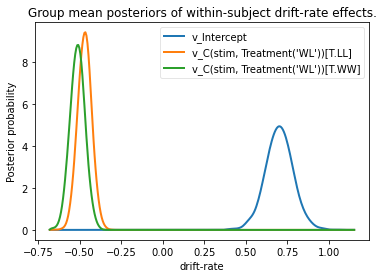

In [31]:
v_WL, v_LL, v_WW = m_reg_all.nodes_db.loc[["v_Intercept",
                                           "v_C(stim, Treatment('WL'))[T.LL]",
                                           "v_C(stim, Treatment('WL'))[T.WW]"], 'node']
hddm.analyze.plot_posterior_nodes([v_WL, v_LL, v_WW])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Group mean posteriors of within-subject drift-rate effects.')
# plt.savefig('hddm_demo_fig_07.pdf')

## Fitting regression models

In [32]:
%%time
m_reg = hddm.HDDMRegressor(data[data.dbs == 0],
                           "a ~ theta:C(conf, Treatment('LC'))",
                           depends_on={'v': 'stim'})
m_reg.sample(5000, burn=1000)

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'a', 'model': " theta:C(conf, Treatment('LC'))", 'params': ['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]", "a_theta:C(conf, Treatment('LC'))[LC]"], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7fe2f07ac940>}
Uses Identity Link
 [-----------------100%-----------------] 5001 of 5000 complete in 1692.5 secCPU times: user 28min 14s, sys: 13.4 s, total: 28min 28s
Wall time: 28min 13s


P(a_theta < 0) =  0.04825


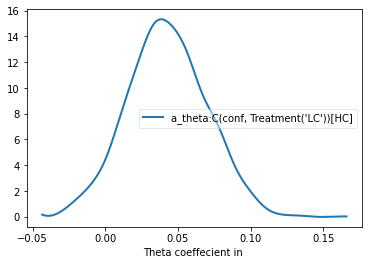

In [33]:
theta = m_reg.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=20)
plt.xlabel('Theta coeffecient in ')
print("P(a_theta < 0) = ", (theta.trace() < 0).mean())

In [34]:
%%time
m_reg_off = hddm.HDDMRegressor(data[data.dbs == 1],
                               "a ~ theta:C(conf, Treatment('LC'))",
                               depends_on={'v': 'stim'})
m_reg_off.sample(5000, burn=1000)

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
Reg Model:
{'outcome': 'a', 'model': " theta:C(conf, Treatment('LC'))", 'params': ['a_Intercept', "a_theta:C(conf, Treatment('LC'))[HC]", "a_theta:C(conf, Treatment('LC'))[LC]"], 'link_func': <function HDDMRegressor.__init__.<locals>.<lambda> at 0x7fe2e17d9310>}
Uses Identity Link
 [-----------------100%-----------------] 5000 of 5000 complete in 1603.0 secCPU times: user 26min 45s, sys: 9.58 s, total: 26min 54s
Wall time: 26min 43s


P(a_theta > 0) =  0.048


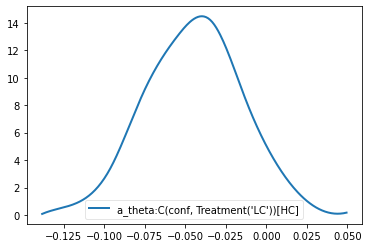

In [35]:
theta = m_reg_off.nodes_db.node["a_theta:C(conf, Treatment('LC'))[HC]"]
hddm.analyze.plot_posterior_nodes([theta], bins=10)
print("P(a_theta > 0) = ", (theta.trace() > 0).mean())

## Dealing with outliers

This part of the tutorial seems outdated because, since 0.6.0, HDDM has a default setting `p_outliers=.05`. 

In [36]:
outlier_data, params = hddm.generate.gen_rand_data(params={'a': 2, 't': .4, 'v': .5},
                                                   size=200, n_fast_outliers=10)

/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [37]:
m_no_outlier = hddm.HDDM(outlier_data)
m_no_outlier.sample(2000, burn=50)

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
 [-----------------100%-----------------] 2000 of 2000 complete in 6.2 sec

Text(0, 0.5, 'Probability density')

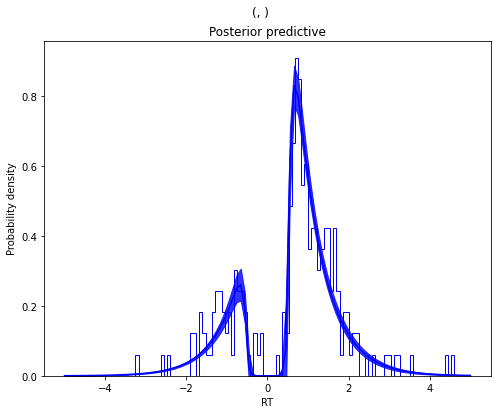

In [38]:
m_no_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')
# plt.savefig('hddm_demo_fig_10.pdf')

In [39]:
m_outlier = hddm.HDDM(outlier_data, p_outlier=.05)
m_outlier.sample(2000, burn=20)

No model attribute --> setting up standard HDDM
Includes supplied:  ()
Set model to ddm
 [-----------------100%-----------------] 2000 of 2000 complete in 6.1 sec

Text(0, 0.5, 'Probability density')

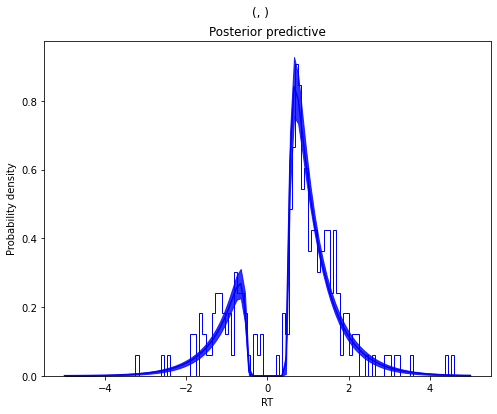

In [40]:
m_outlier.plot_posterior_predictive()
plt.title('Posterior predictive')
plt.xlabel('RT')
plt.ylabel('Probability density')
# plt.savefig('hddm_demo_fig_11.pdf')